# Customer Profiling: NMF + K-Means Clustering

Latent Factor Modeling (NMF)과 Clustering (K-Means)을 사용한 고객 프로파일링.

**목표:**
1. 고객 행동의 Latent Dimension 발견 (NMF)
2. 실행 가능한 고객 세그먼트 도출 (K-Means)
3. 세그먼트 안정성 및 해석가능성 검증

## Executive Summary

### 주요 발견
- NMF와 K-Means를 사용하여 **7개의 고유한 고객 세그먼트** 식별
- 고객 행동 분산의 **92.44%**를 설명하는 **5개의 해석 가능한 Factor**
- Bootstrap 검증으로 확인된 높은 세그먼트 안정성 (**ARI = 0.77**)
- 세그먼트별 명확한 마케팅 액션 도출

### 세그먼트 개요
| 세그먼트 | 규모 | 평균 매출 | 특성 |
|----------|------|----------|------|
| VIP Heavy | 12% | $9,716 | 최고 가치, One-stop 쇼퍼 |
| Active Loyalists | 20% | $3,878 | 고빈도, PB 선호 |
| Regular + H&B | 13% | $3,393 | 정기적, H&B 집중 |
| Bulk Shoppers | 13% | $3,206 | 대량 구매, 낮은 빈도 |
| Fresh Lovers | 14% | $1,233 | 신선식품 전문가 |
| Light Grocery | 21% | $1,100 | 가벼운 관여 |
| Lapsed H&B | 8% | $872 | 이탈, H&B 집중 |

## 목차

1. [서론](#1.-Introduction)
   - 1.1 배경 및 목표
   - 1.2 방법론 개요
2. [데이터 전처리](#2.-Data-Preprocessing)
   - 2.1 Feature 선택
   - 2.2 정규화
3. [NMF 분석](#3.-NMF-Analysis)
   - 3.1 Component 선택
   - 3.2 Factor 해석
   - 3.3 고객 Factor Score
4. [K-Means Clustering](#4.-K-Means-Clustering)
   - 4.1 최적 k 선택
   - 4.2 알고리즘 비교
5. [세그먼트 프로파일링](#5.-Segment-Profiling)
   - 5.1 세그먼트 크기
   - 5.2 Feature 프로필
   - 5.3 Factor Score 프로필
6. [안정성 분석](#6.-Stability-Analysis)
   - 6.1 Bootstrap 검증
7. [2D 세그먼트 포지셔닝](#7.-2D-Segment-Positioning)
   - 7.1 Bubble Chart (8가지 차원 조합)
8. [결과 Export](#8.-Export-Results)

---

## 1. 서론

### 1.1 배경 및 목표

**비즈니스 컨텍스트:** 고객 세분화는 현대 리테일 마케팅 전략의 핵심이다. 고객의 행동 패턴을 기반으로 그룹화함으로써, 리테일러는 타겟 마케팅 활동을 개발하고 투자 수익률을 극대화할 수 있다.

**목표:**
1. 고객 쇼핑 패턴을 특징짓는 **Latent Behavioral Factor 발견**
2. 실행 가능한 마케팅 시사점을 가진 **고유한 고객 세그먼트 식별**
3. Bootstrap Resampling을 통한 **세그먼트 안정성 검증**

### 1.2 방법론 개요

**Step 1: Latent Factor Modeling (NMF)**
- 33개 고객 Feature → 5개 Latent Factor
- Reconstruction Error 기반 Component 선택
- Factor 해석을 통한 차원 명명

**Step 2: Clustering (K-Means)**
- NMF Factor Score를 입력으로 사용
- 다중 메트릭 기반 최적 k 선택
- Bootstrap 안정성 검증

In [40]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Project paths
PROJECT_PATH = Path('.').absolute().parents[0]
DATA_PATH = PROJECT_PATH.parents[1] / 'data' / 'dunnhumby'
PROCESSED_PATH = DATA_PATH / 'processed'

print('Project path:', PROJECT_PATH)
print('Data path:', DATA_PATH)
print('Processed path:', PROCESSED_PATH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project path: /Users/taehyun/project/side-projects/projects/kr_segmentation_causal_targeting_dunnhumby
Data path: /Users/taehyun/project/side-projects/data/dunnhumby
Processed path: /Users/taehyun/project/side-projects/data/dunnhumby/processed


In [41]:
# Import segmentation module
from projects.segmentation_causal_targeting_dunnhumby.src.segments import (
    # Config objects
    NMFConfig,
    ClusterConfig,
    # Result objects
    NMFResult,
    ClusterResult,
    StabilityResult,
    PipelineResult,
    # NMF functions
    train_nmf,
    compute_nmf_metrics,
    interpret_factors,
    create_factor_dataframes,
    # Clustering functions
    train_clustering,
    evaluate_clustering,
    compare_clustering_methods,
    # Profiling functions
    profile_segments,
    compute_segment_sizes,
    test_segment_differences,
    standardize_profiles,
    # Stability functions
    bootstrap_stability,
    # Pipeline
    run_nmf_clustering_pipeline,
    # Visualization
    plot_cluster_bubble,
    plot_cluster_bubble_grid,
)

# Import feature constants
from projects.segmentation_causal_targeting_dunnhumby.src.features import (
    FEATURE_COLS,
    TRACK1_FEATURE_COLS,
    FEATURE_COLS_REDUCED,
    TRACK1_REDUCED_COLS,
)

# Results paths for figure/table exports
RESULTS_PATH = Path('.').absolute().parents[2] / 'projects' / 'segmentation_causal_targeting_dunnhumby' / 'results'
FIG_PATH = RESULTS_PATH / 'figures'
TABLE_PATH = RESULTS_PATH / 'tables'

In [42]:
# Load Track 1 features
df_features = pd.read_parquet(PROCESSED_PATH / 'features_track1.parquet')

print(f"Feature matrix: {df_features.shape}")
print(f"Customers: {len(df_features):,}")
print(f"Full features: {len(TRACK1_FEATURE_COLS)}")
print(f"Reduced features: {len(TRACK1_REDUCED_COLS)}")
print(f"\nFull feature groups:")
for group in ['recency', 'frequency', 'monetary', 'behavioral', 'category', 'time']:
    print(f"  - {group}: {len(FEATURE_COLS[group])} features")

df_features.head()

Feature matrix: (2500, 36)
Customers: 2,500
Full features: 33
Reduced features: 19

Full feature groups:
  - recency: 6 features
  - frequency: 6 features
  - monetary: 7 features
  - behavioral: 7 features
  - category: 6 features
  - time: 1 features


,household_key,recency,recency_weeks,active_last_4w,active_last_12w,days_between_purchases_avg,days_between_purchases_std,frequency,frequency_per_week,frequency_per_month,...,n_products,avg_items_per_basket,avg_products_per_basket,share_alcohol,share_bakery,share_fresh,share_grocery,share_health_beauty,share_other,week_coverage
0,1,5,0,1,1,8.506494,4.551647,85,0.894737,3.874211,...,674,23.494118,7.929412,0.0,0.022011,0.200563,0.636235,0.133764,0.007427,0.715789
1,2,43,6,0,1,12.840909,14.445734,45,0.511364,2.214205,...,545,18.533333,12.111111,0.0,0.012700,0.220637,0.569241,0.183991,0.013432,0.426829
2,3,8,1,1,1,13.111111,12.438689,47,0.546512,2.366395,...,515,181.702128,10.957447,0.0,0.001240,0.258114,0.672676,0.060429,0.007542,0.435294
3,4,84,12,0,1,18.034483,17.527285,30,0.344828,1.493103,...,164,12.733333,5.466667,0.0,0.000000,0.147478,0.582222,0.270300,0.000000,0.346667
4,5,8,1,1,1,19.312500,22.187324,40,0.444444,1.924444,...,199,6.125000,4.975000,0.0,0.003055,0.260558,0.460979,0.275409,0.000000,0.303371


---

## 2. 데이터 전처리

NMF 분석을 위한 Feature 준비 (비음수 입력 필요).

### 2.1 Feature Selection

Use reduced 19 features (removed redundant/highly correlated features for better NMF factor separation).

In [43]:
# Use reduced feature set (19 features, removed redundant/correlated)
SELECTED_FEATURES = TRACK1_REDUCED_COLS.copy()

print(f"Selected features: {len(SELECTED_FEATURES)} (reduced from 33)")
print(f"\nFeatures by group:")
for group in ['recency', 'frequency', 'monetary', 'behavioral', 'category']:
    features = FEATURE_COLS_REDUCED[group]
    print(f"  {group}: {features}")

Selected features: 19 (reduced from 33)

Features by group:
  recency: ['recency', 'days_between_purchases_avg']
  frequency: ['frequency', 'frequency_per_week', 'purchase_regularity']
  monetary: ['monetary_sales', 'monetary_avg_basket_sales', 'monetary_std', 'coupon_savings_ratio']
  behavioral: ['discount_usage_pct', 'private_label_ratio', 'n_departments', 'n_products', 'avg_items_per_basket']
  category: ['share_grocery', 'share_fresh', 'share_bakery', 'share_health_beauty', 'share_alcohol']


In [44]:
# Check for missing values
X_raw = df_features[SELECTED_FEATURES]

print("Missing values check:")
missing = X_raw.isnull().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print(missing)
else:
    print("  No missing values")

# Check for negative values
print("\nNegative values check:")
neg_cols = [col for col in SELECTED_FEATURES if (X_raw[col] < 0).any()]
if neg_cols:
    print(f"  Columns with negative values: {neg_cols}")
else:
    print("  No negative values")

Missing values check:
  No missing values

Negative values check:
  No negative values


### 2.2 Scaling for NMF

Apply MinMaxScaler to ensure all features are non-negative and in [0, 1] range.

In [45]:
# MinMax scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

# Create DataFrame for reference
df_scaled = pd.DataFrame(
    X_scaled,
    columns=SELECTED_FEATURES,
    index=df_features['household_key']
)

print(f"Scaled feature matrix: {X_scaled.shape}")
print(f"Value range: [{X_scaled.min():.4f}, {X_scaled.max():.4f}]")

df_scaled.describe()

Scaled feature matrix: (2500, 19)
Value range: [0.0000, 1.0000]


,recency,days_between_purchases_avg,frequency,frequency_per_week,purchase_regularity,monetary_sales,monetary_avg_basket_sales,monetary_std,coupon_savings_ratio,discount_usage_pct,private_label_ratio,n_departments,n_products,avg_items_per_basket,share_grocery,share_fresh,share_bakery,share_health_beauty,share_alcohol
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,0.038928,0.028985,0.084314,0.082618,0.528419,0.083912,0.179284,0.208225,0.040429,0.523393,0.332139,0.516273,0.176455,0.044508,0.505576,0.289438,0.031100,0.172433,0.004584
std,0.095573,0.047937,0.089000,0.087414,0.276107,0.087415,0.116812,0.117555,0.082162,0.122807,0.123394,0.162871,0.138324,0.076057,0.121833,0.122479,0.047976,0.116599,0.029655
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001522,0.008843,0.028527,0.028127,0.295629,0.025125,0.097993,0.124051,0.000000,0.444058,0.244935,0.409091,0.071975,0.000731,0.431238,0.207225,0.008139,0.089722,0.000000
50%,0.009132,0.015553,0.059368,0.057769,0.529773,0.056108,0.153464,0.186465,0.012433,0.522100,0.322609,0.500000,0.142994,0.008328,0.512051,0.280043,0.020227,0.147509,0.000000
75%,0.030441,0.030912,0.108712,0.106398,0.766081,0.114982,0.233917,0.268545,0.041874,0.600100,0.409636,0.636364,0.248408,0.059085,0.582807,0.357782,0.038594,0.221181,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
# Correlation matrix for reference (will help interpret NMF factors)
corr_matrix = df_scaled.corr()

# Highly correlated pairs
threshold = 0.9
high_corr_pairs = []
for i, col1 in enumerate(SELECTED_FEATURES):
    for col2 in SELECTED_FEATURES[i+1:]:
        c = corr_matrix.loc[col1, col2]
        if abs(c) >= threshold:
            high_corr_pairs.append((col1, col2, c))

print(f"Highly correlated pairs (|r| >= {threshold}):")
for col1, col2, c in sorted(high_corr_pairs, key=lambda x: -abs(x[2]))[:10]:
    print(f"  {col1} <-> {col2}: {c:.2f}")
print(f"\n(Total: {len(high_corr_pairs)} pairs)")

Highly correlated pairs (|r| >= 0.9):
  frequency <-> frequency_per_week: 1.00

(Total: 1 pairs)


---

## 3. NMF Factor Analysis

Discover latent customer dimensions using Non-negative Matrix Factorization.

### 3.1 Component Selection

Evaluate reconstruction error and explained variance across component range.

In [47]:
# Evaluate NMF across component range
n_range = range(2, 12)
nmf_metrics = compute_nmf_metrics(X_scaled, n_range)

print("NMF Metrics:")
display(nmf_metrics)

NMF Metrics:


/opt/anaconda3/envs/side-projects/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


,n_components,reconstruction_error,explained_variance,sparsity_W,sparsity_H
0,2,18.556993,0.850058,59.666067,4.138897
1,3,16.328885,0.883947,71.455106,4.412749
2,4,14.756530,0.905226,82.982903,4.431016
3,5,13.183858,0.924413,90.202963,4.476859
4,6,11.902302,0.938377,89.003024,4.743938
5,7,10.779901,0.949448,103.462354,4.576769
6,8,9.693004,0.959142,101.625492,4.722001
7,9,8.736533,0.966843,107.210923,5.094074
8,10,7.444011,0.975911,104.042021,4.998293
9,11,6.424817,0.982053,104.340580,4.717674


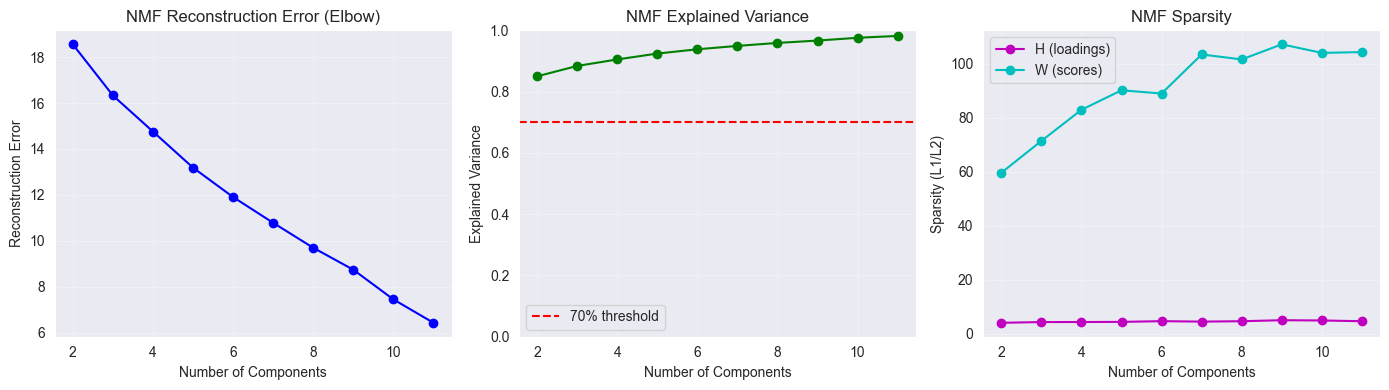

In [48]:
# Plot NMF metrics
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Reconstruction error
ax = axes[0]
ax.plot(nmf_metrics['n_components'], nmf_metrics['reconstruction_error'], 'bo-')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Reconstruction Error')
ax.set_title('NMF Reconstruction Error (Elbow)')
ax.grid(True, alpha=0.3)

# Explained variance
ax = axes[1]
ax.plot(nmf_metrics['n_components'], nmf_metrics['explained_variance'], 'go-')
ax.axhline(y=0.7, color='r', linestyle='--', label='70% threshold')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance')
ax.set_title('NMF Explained Variance')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)

# Sparsity
ax = axes[2]
ax.plot(nmf_metrics['n_components'], nmf_metrics['sparsity_H'], 'mo-', label='H (loadings)')
ax.plot(nmf_metrics['n_components'], nmf_metrics['sparsity_W'], 'co-', label='W (scores)')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Sparsity (L1/L2)')
ax.set_title('NMF Sparsity')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIG_PATH / 'nmf_component_selection.png', dpi=150, bbox_inches='tight')
plt.show()

In [49]:
# Select optimal number of components
# Based on elbow in reconstruction error and explained variance > 70%
# n=5 provides clear, interpretable factors without over-factoring
N_COMPONENTS = 5

selected_row = nmf_metrics[nmf_metrics['n_components'] == N_COMPONENTS].iloc[0]
print(f"Selected n_components: {N_COMPONENTS}")
print(f"  Reconstruction error: {selected_row['reconstruction_error']:.4f}")
print(f"  Explained variance: {selected_row['explained_variance']:.2%}")

Selected n_components: 5
  Reconstruction error: 13.1839
  Explained variance: 92.44%


### 3.2 Fit NMF Model

In [50]:
# Create NMF config and train
nmf_config = NMFConfig(n_components=N_COMPONENTS)
nmf_result = train_nmf(X_scaled, nmf_config)

print(f"NMF Model fitted:")
print(f"  W (customer scores): {nmf_result.W.shape}")
print(f"  H (factor loadings): {nmf_result.H.shape}")
print(f"  Reconstruction error: {nmf_result.reconstruction_error:.4f}")
print(f"  Iterations: {nmf_result.n_iter}")

NMF Model fitted:
  W (customer scores): (2500, 5)
  H (factor loadings): (5, 19)
  Reconstruction error: 13.1839
  Iterations: 300


In [51]:
# Create DataFrames for factor scores and loadings
df_factor_scores, df_factor_loadings = create_factor_dataframes(
    nmf_result,
    customer_index=df_features['household_key'],
    feature_names=SELECTED_FEATURES
)

print("Factor Scores (customer x factors):")
display(df_factor_scores.head())

print("\nFactor Loadings (features x factors):")
display(df_factor_loadings)

Factor Scores (customer x factors):


,factor_1,factor_2,factor_3,factor_4,factor_5
household_key,,,,,
1,0.051930,0.115797,0.106409,0.019064,0.030828
2,0.049530,0.057623,0.093204,0.078043,0.087518
3,0.056178,0.053527,0.143569,0.079239,0.016036
4,0.052601,0.030111,0.078690,0.034960,0.143766
5,0.058409,0.030985,0.019973,0.106799,0.140709



Factor Loadings (features x factors):


,factor_1,factor_2,factor_3,factor_4,factor_5
recency,0.000000,0.000000,0.000000,0.192558,0.412149
days_between_purchases_avg,0.019150,0.000000,0.000000,0.179119,0.198828
frequency,0.000000,1.043210,0.000000,0.000000,0.000000
frequency_per_week,0.000000,1.022719,0.000000,0.000000,0.000000
purchase_regularity,1.846976,4.626825,0.000513,0.255079,0.000000
monetary_sales,0.000000,0.817512,0.407122,0.000000,0.000000
monetary_avg_basket_sales,0.000346,0.000000,2.350587,0.223385,0.220329
monetary_std,0.329910,0.001821,2.451860,0.247119,0.253530
coupon_savings_ratio,0.522815,0.081161,0.086427,0.000000,0.021689
discount_usage_pct,5.130739,0.583379,1.066212,1.011620,0.501851


### 3.3 Factor Interpretation

Analyze top-loading features for each factor to assign meaningful names.

**Factor Interpretation Guide:**
| Factor | Name | Key Features | Customer Profile |
|--------|------|--------------|------------------|
| F1 | Grocery Deal Seeker | grocery, discount, PL | Grocery-focused, discount/PB preference |
| F2 | Loyal Regular | regularity, n_dept, n_products | Consistent shopping across categories |
| F3 | Big Basket | monetary_std, avg_basket | Large basket size, high variability |
| F4 | Fresh Focused | share_fresh, PL | Fresh produce/meat centered |
| F5 | Health & Beauty | share_h&b | Health/beauty product focused |

In [52]:
# Get top features for each factor
factor_interpretations = interpret_factors(df_factor_loadings, top_n=6)

print("Top Features by Factor:")
print("=" * 60)
for factor, top_features in factor_interpretations.items():
    print(f"\n{factor}:")
    for feature, loading in top_features.items():
        print(f"  {feature}: {loading:.3f}")

Top Features by Factor:

factor_1:
  share_grocery: 6.716
  discount_usage_pct: 5.131
  private_label_ratio: 3.406
  purchase_regularity: 1.847
  n_departments: 0.736
  coupon_savings_ratio: 0.523

factor_2:
  purchase_regularity: 4.627
  n_departments: 2.613
  n_products: 1.528
  frequency: 1.043
  frequency_per_week: 1.023
  monetary_sales: 0.818

factor_3:
  monetary_std: 2.452
  monetary_avg_basket_sales: 2.351
  share_grocery: 2.080
  n_departments: 1.476
  discount_usage_pct: 1.066
  n_products: 0.873

factor_4:
  share_fresh: 2.260
  n_departments: 1.210
  private_label_ratio: 1.054
  discount_usage_pct: 1.012
  purchase_regularity: 0.255
  monetary_std: 0.247

factor_5:
  share_health_beauty: 2.027
  n_departments: 0.728
  discount_usage_pct: 0.502
  recency: 0.412
  monetary_std: 0.254
  monetary_avg_basket_sales: 0.220


In [79]:
FIG_PATH

PosixPath('/Users/taehyun/project/side-projects/projects/segmentation_causal_targeting_dunnhumby/results/figures')

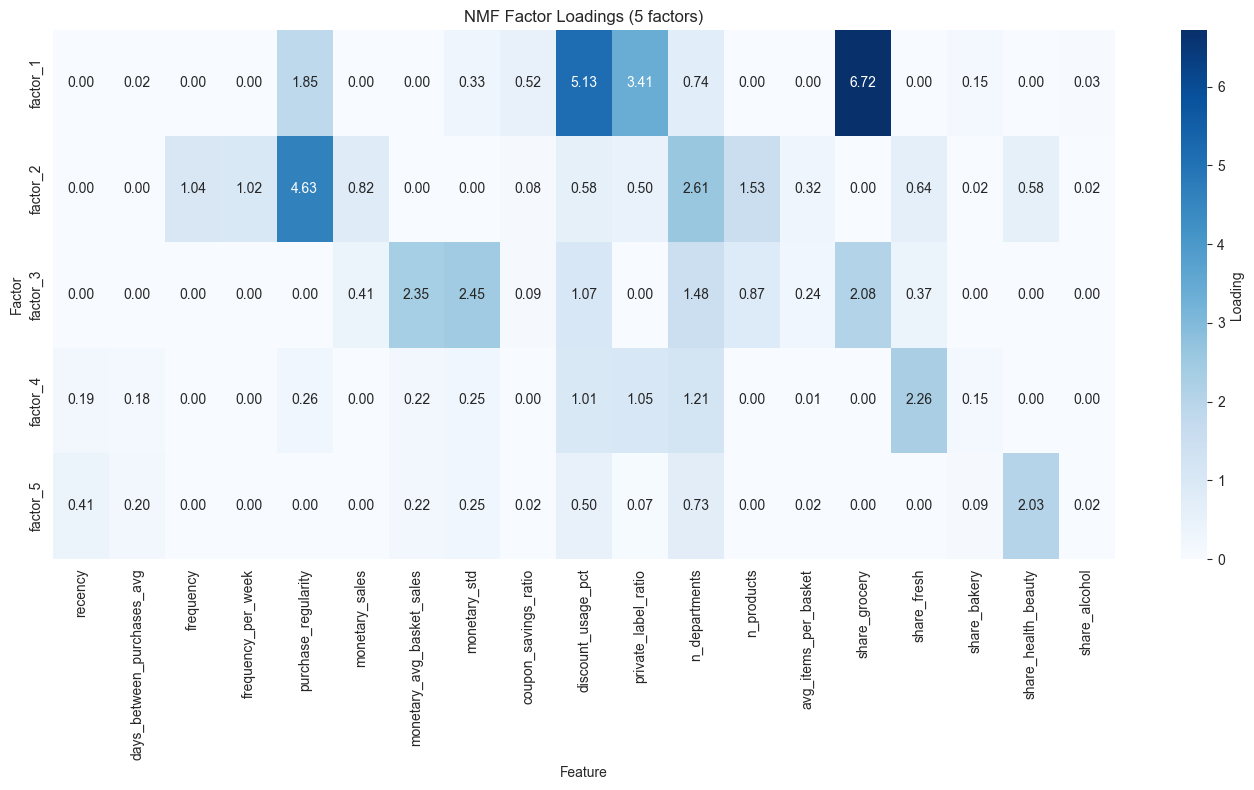

In [80]:
# Factor loadings heatmap
fig, ax = plt.subplots(figsize=(14, 8))

sns.heatmap(
    df_factor_loadings.T,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    ax=ax,
    cbar_kws={'label': 'Loading'}
)

ax.set_title(f'NMF Factor Loadings ({N_COMPONENTS} factors)', fontsize=12)
ax.set_xlabel('Feature')
ax.set_ylabel('Factor')
plt.tight_layout()
fig.savefig(FIG_PATH / 'factor_loadings_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [54]:
# Assign factor names based on interpretation
FACTOR_NAMES = {
    'factor_1': 'Grocery Deal Seeker',   # share_grocery (6.7), discount_pct (5.1), PL (3.4)
    'factor_2': 'Loyal Regular',          # purchase_regularity (4.6), n_dept (2.6), n_products (1.5)
    'factor_3': 'Big Basket',             # monetary_std (2.5), avg_basket (2.4)
    'factor_4': 'Fresh Focused',          # share_fresh (2.3), PL (1.1)
    'factor_5': 'Health & Beauty',        # share_health_beauty (2.0)
}

# Create named version
df_factor_scores_named = df_factor_scores.rename(columns=FACTOR_NAMES)
df_factor_loadings_named = df_factor_loadings.rename(columns=FACTOR_NAMES)

print("Factor Names & Interpretation:")
print("=" * 70)
interpretations = {
    'factor_1': 'Grocery-focused customers with strong discount/PB preference',
    'factor_2': 'Loyal customers shopping consistently across categories',
    'factor_3': 'Large basket shoppers with high purchase variability',
    'factor_4': 'Fresh produce/meat centered customers',
    'factor_5': 'Health & beauty product focused customers',
}
for old, new in FACTOR_NAMES.items():
    print(f"  {old} -> {new}")
    print(f"           {interpretations[old]}")

Factor Names & Interpretation:
  factor_1 -> Grocery Deal Seeker
           Grocery-focused customers with strong discount/PB preference
  factor_2 -> Loyal Regular
           Loyal customers shopping consistently across categories
  factor_3 -> Big Basket
           Large basket shoppers with high purchase variability
  factor_4 -> Fresh Focused
           Fresh produce/meat centered customers
  factor_5 -> Health & Beauty
           Health & beauty product focused customers


### Detailed Factor Interpretation

---

#### Factor 1: Grocery Deal Seeker

**Key Features:** `share_grocery (6.7)`, `discount_pct (5.1)`, `PL_ratio (3.4)`, `regularity (1.8)`

**Why this combination?**
- Grocery = staples → requires repeat purchase → high regularity
- Price-sensitive → prefers both discounts AND private label
- Pattern: "Budget-conscious planned shopper"

**Customer Profile:** Shops regularly for groceries, actively uses discounts/PB to save money

**Marketing Strategy:** PB promotions, regular discount coupons, grocery bundles

---

#### Factor 2: Loyal Regular

**Key Features:** `regularity (4.6)`, `n_dept (2.6)`, `n_products (1.5)`, `frequency (1.0)`

**Why this combination?**
- Regular visits → naturally explores diverse categories
- Diverse categories → high n_products
- Consistency + diversity = high total sales contribution

**Customer Profile:** One-stop shopper who does most shopping at this store

**Marketing Strategy:** VIP membership, cross-selling, new product early access

---

#### Factor 3: Big Basket

**Key Features:** `monetary_std (2.5)`, `avg_basket (2.4)`, `share_grocery (2.1)`, `n_dept (1.5)`

**Why this combination?**
- Bulk purchasing → high avg_basket
- Irregular bulk trips → high monetary_std (variability)
- One trip covers multiple categories → n_departments

**Customer Profile:** Monthly bulk shopper, warehouse/Costco-style purchasing pattern

**Marketing Strategy:** Bulk discounts, bundle deals, clearance sale targeting

---

#### Factor 4: Fresh Focused

**Key Features:** `share_fresh (2.3)`, `n_dept (1.2)`, `PL_ratio (1.1)`, `discount_pct (1.0)`

**Why this combination?**
- Fresh produce/meat centered purchasing
- Fresh items → frequent visits needed (perishability)
- Store-brand fresh (e.g., in-house butcher) preference

**Customer Profile:** Health/cooking conscious, prefers raw ingredients over processed

**Marketing Strategy:** Daily fresh specials, farm-to-store promos, recipe suggestions

---

#### Factor 5: Health & Beauty

**Key Features:** `share_h&b (2.0)`, `n_dept (0.7)`, `discount_pct (0.5)`

**Why this combination?**
- H&B products (cosmetics, supplements, pharmacy) specialized
- Purpose-driven shopping → focused categories
- H&B has high brand loyalty → lower discount sensitivity

**Customer Profile:** Drugstore-type customer, health/beauty focused, purpose shopper

**Marketing Strategy:** H&B new product sampling, beauty membership, supplement promos

---

#### Factor Comparison Summary

| Factor | Core Keyword | Purchase Pattern | Price Sensitivity |
|--------|--------------|------------------|-------------------|
| **F1** Grocery Deal | Savings, Planned | Regular, Grocery | **High** |
| **F2** Loyal Regular | Loyalty, Variety | Regular, All categories | Medium |
| **F3** Big Basket | Bulk, Variable | Irregular, Large basket | Medium |
| **F4** Fresh Focused | Fresh, Health | Frequent, Fresh produce | Medium |
| **F5** Health & Beauty | Purpose, Focused | As needed, H&B only | **Low** |

---

## 4. Clustering on NMF Factors

Derive customer segments by clustering on NMF factor scores.

### 4.1 Optimal Cluster Selection

Evaluate clustering metrics across k range.

In [55]:
# Evaluate clustering metrics
k_range = range(2, 11)
cluster_metrics = evaluate_clustering(nmf_result.W, k_range, method='kmeans')

print("Clustering Metrics (K-Means):")
display(cluster_metrics)

Clustering Metrics (K-Means):


,k,silhouette,calinski_harabasz,davies_bouldin,inertia
0,2,0.265950,992.523446,1.425985,22.603214
1,3,0.271187,984.883089,1.256304,17.656048
2,4,0.244244,846.018439,1.313587,15.660282
3,5,0.224607,794.168213,1.320813,13.894008
4,6,0.207045,756.304880,1.341691,12.552110
5,7,0.219381,731.996752,1.240969,11.436358
6,8,0.208899,700.200754,1.244311,10.645638
7,9,0.206004,668.217535,1.285629,10.039370
8,10,0.201553,637.204306,1.266346,9.561834


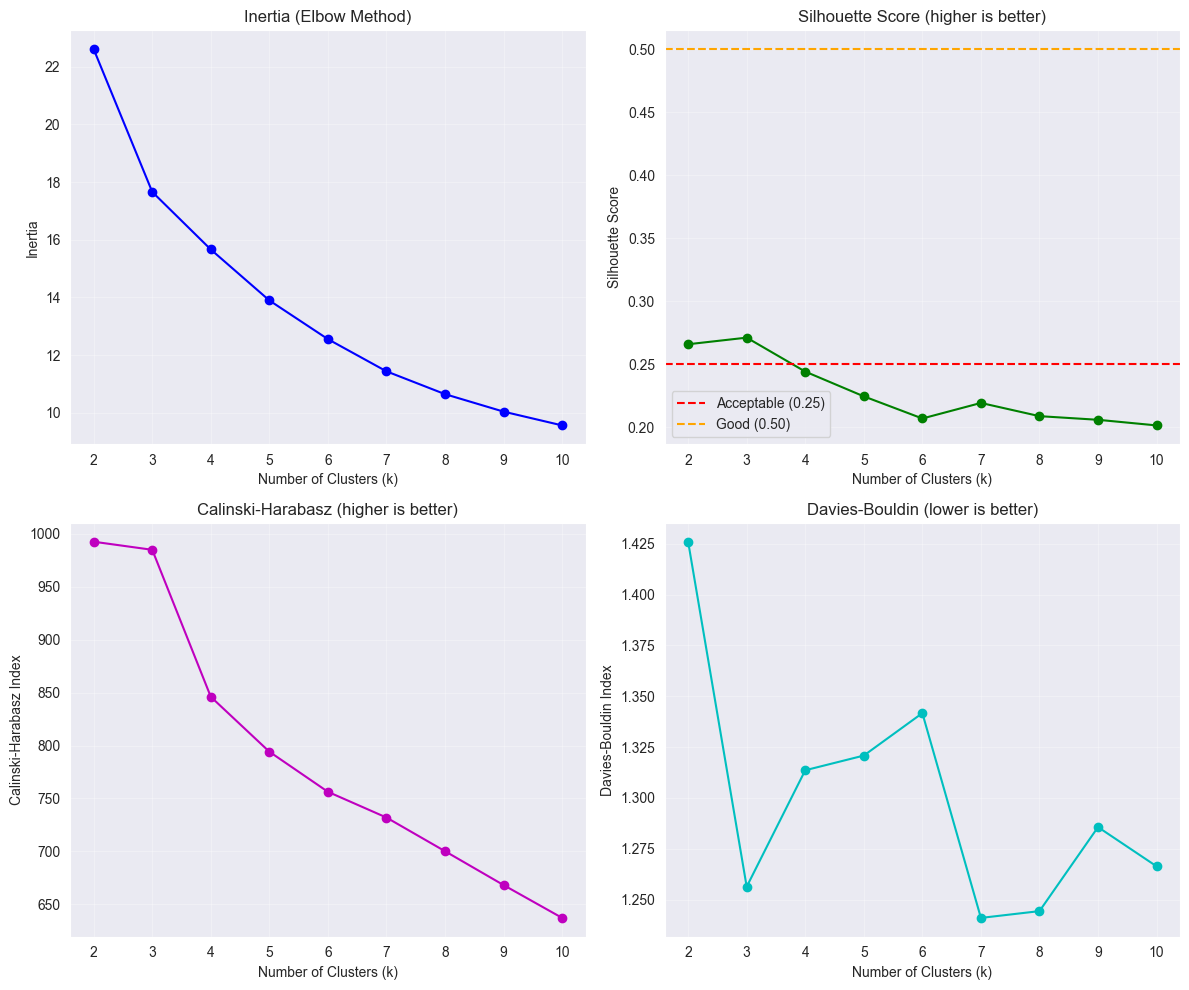

In [56]:
# Plot clustering metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Inertia (Elbow)
ax = axes[0, 0]
ax.plot(cluster_metrics['k'], cluster_metrics['inertia'], 'bo-')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Inertia')
ax.set_title('Inertia (Elbow Method)')
ax.grid(True, alpha=0.3)

# Silhouette Score
ax = axes[0, 1]
ax.plot(cluster_metrics['k'], cluster_metrics['silhouette'], 'go-')
ax.axhline(y=0.25, color='r', linestyle='--', label='Acceptable (0.25)')
ax.axhline(y=0.50, color='orange', linestyle='--', label='Good (0.50)')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score (higher is better)')
ax.legend()
ax.grid(True, alpha=0.3)

# Calinski-Harabasz
ax = axes[1, 0]
ax.plot(cluster_metrics['k'], cluster_metrics['calinski_harabasz'], 'mo-')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Calinski-Harabasz Index')
ax.set_title('Calinski-Harabasz (higher is better)')
ax.grid(True, alpha=0.3)

# Davies-Bouldin
ax = axes[1, 1]
ax.plot(cluster_metrics['k'], cluster_metrics['davies_bouldin'], 'co-')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Davies-Bouldin Index')
ax.set_title('Davies-Bouldin (lower is better)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIG_PATH / 'clustering_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

In [57]:
# Select optimal k
N_CLUSTERS = 7  # Adjust based on above plots

selected_k_row = cluster_metrics[cluster_metrics['k'] == N_CLUSTERS].iloc[0]
print(f"Selected k: {N_CLUSTERS}")
print(f"  Silhouette: {selected_k_row['silhouette']:.3f}")
print(f"  Calinski-Harabasz: {selected_k_row['calinski_harabasz']:.1f}")
print(f"  Davies-Bouldin: {selected_k_row['davies_bouldin']:.3f}")

Selected k: 7
  Silhouette: 0.219
  Calinski-Harabasz: 732.0
  Davies-Bouldin: 1.241


#### Clustering Metrics Explained

| Metric | Measures | Good Value | Interpretation |
|--------|----------|------------|----------------|
| **Silhouette** | How well each point fits its cluster vs nearest other cluster | Higher (+1 max) | Individual sample "belonging" score |
| **Calinski-Harabasz** | Between-cluster variance / Within-cluster variance | Higher | Like ANOVA F-ratio; naturally decreases with k |
| **Davies-Bouldin** | Cluster dispersion relative to separation | **Lower (0 min)** | "Worst-case" similarity between clusters |

**Silhouette Score Benchmarks:**
- 0.71-1.00: Strong structure
- 0.51-0.70: Reasonable structure  
- 0.26-0.50: Weak structure
- < 0.25: No substantial structure (or inherently fuzzy data)

#### k=7 Selection Rationale

| k | Silhouette | Davies-Bouldin | Assessment |
|---|------------|----------------|------------|
| 3 | 0.271 (Best) | 1.256 | Too broad for actionable marketing |
| 6 | 0.207 | 1.342 (Worst) | Poor cluster separation |
| **7** | 0.219 | **1.241 (Best)** | Optimal separation + granularity |
| 8 | 0.209 | 1.244 | Similar to k=7, more complexity |

**Why k=7?**
1. **Best Davies-Bouldin (1.241)**: Clusters are most clearly separated
2. **Silhouette recovery**: 0.219 (up from 0.207 at k=6)
3. **Practical granularity**: 7 segments enable differentiated marketing strategies
4. **Note**: Lower silhouette is expected in behavioral data due to inherent continuity of customer behavior

### 4.2 K-Means vs GMM Comparison

In [58]:
# Compare K-Means and GMM
comparison = compare_clustering_methods(nmf_result.W, N_CLUSTERS)

print("Method Comparison:")
print("=" * 50)
for method, result in comparison.items():
    print(f"\n{method.upper()}:")
    print(f"  Silhouette: {result.silhouette:.3f}")
    print(f"  Calinski-Harabasz: {result.calinski_harabasz:.1f}")
    print(f"  Davies-Bouldin: {result.davies_bouldin:.3f}")

Method Comparison:

KMEANS:
  Silhouette: 0.219
  Calinski-Harabasz: 732.0
  Davies-Bouldin: 1.241

GMM:
  Silhouette: 0.047
  Calinski-Harabasz: 306.8
  Davies-Bouldin: 2.456


### 4.3 Final Clustering

In [59]:
# Create cluster config and train
cluster_config = ClusterConfig(n_clusters=N_CLUSTERS, method='kmeans')
cluster_result = train_clustering(nmf_result.W, cluster_config)

# Add segment to feature DataFrame
df_segments = df_features.copy()
df_segments['segment'] = cluster_result.labels

# Add factor scores
for factor in df_factor_scores.columns:
    df_segments[factor] = df_factor_scores[factor].values

print(f"Clustering complete: {N_CLUSTERS} segments using {cluster_config.method}")
print(f"  Silhouette: {cluster_result.silhouette:.3f}")
print(f"\nSegment distribution:")
print(df_segments['segment'].value_counts().sort_index())

Clustering complete: 7 segments using kmeans
  Silhouette: 0.219

Segment distribution:
segment
0    509
1    299
2    193
3    339
4    524
5    318
6    318
Name: count, dtype: int64


---

## 5. Segment Profiling

Characterize and name the segments based on their feature profiles and factor scores.

### 5.1 Segment Sizes

In [60]:
# Compute segment sizes
segment_sizes = compute_segment_sizes(df_segments, 'segment')

print("Segment Sizes:")
display(segment_sizes)

# Check minimum size
min_proportion = segment_sizes['proportion'].min()
print(f"\nSmallest segment: {min_proportion:.1%}")
if min_proportion < 0.05:
    print("  WARNING: Segment smaller than 5%")
else:
    print("  OK: All segments >= 5%")

Segment Sizes:


,segment,count,proportion
4,4,524,0.2096
0,0,509,0.2036
3,3,339,0.1356
5,5,318,0.1272
6,6,318,0.1272
1,1,299,0.1196
2,2,193,0.0772



Smallest segment: 7.7%
  OK: All segments >= 5%


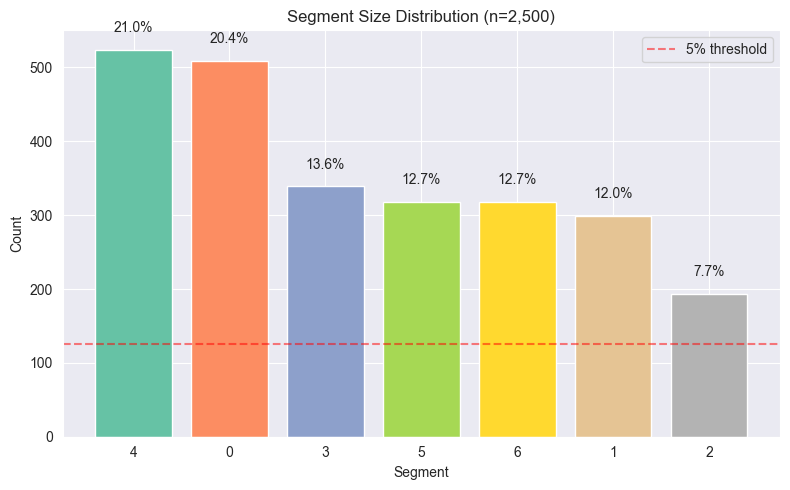

In [61]:
# Plot segment sizes
fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.cm.Set2(np.linspace(0, 1, N_CLUSTERS))
bars = ax.bar(segment_sizes['segment'].astype(str), segment_sizes['count'], color=colors)

# Add proportion labels
for bar, prop in zip(bars, segment_sizes['proportion']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
            f'{prop:.1%}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Segment')
ax.set_ylabel('Count')
ax.set_title(f'Segment Size Distribution (n={len(df_segments):,})')
ax.axhline(y=len(df_segments)*0.05, color='r', linestyle='--', alpha=0.5, label='5% threshold')
ax.legend()

plt.tight_layout()
fig.savefig(FIG_PATH / 'segment_sizes.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.2 Segment Profiles

In [62]:
# Compute segment profiles
profiles = profile_segments(df_segments, SELECTED_FEATURES, 'segment')

print("Segment Profiles (Mean):")
mean_cols = [c for c in profiles.columns if c.endswith('_mean')]
display(profiles[mean_cols].T)

Segment Profiles (Mean):


segment,0,1,2,3,4,5,6
recency_mean,5.764244,3.969900,75.305699,35.858407,41.811069,23.672956,11.610063
days_between_purchases_avg_mean,5.358132,3.952824,37.706567,25.775199,27.098233,20.643247,6.265482
frequency_mean,171.176817,255.826087,37.015544,48.221239,42.690840,56.374214,152.452830
frequency_per_week_mean,1.845235,2.758636,0.399452,0.519234,0.460033,0.604154,1.637332
purchase_regularity_mean,0.775716,0.882123,0.254556,0.340427,0.304513,0.409089,0.695218
monetary_sales_mean,3878.220668,9715.597759,871.784663,1233.345605,942.237061,3205.931572,3392.680943
monetary_avg_basket_sales_mean,24.781442,44.859791,26.242314,26.882664,23.148677,59.190678,25.370049
monetary_std_mean,22.275584,40.971453,23.576497,24.073425,21.548819,52.516686,24.000899
coupon_savings_ratio_mean,0.003703,0.004250,0.002481,0.002072,0.003581,0.003926,0.003903
discount_usage_pct_mean,0.518842,0.481875,0.450688,0.514794,0.511271,0.496413,0.480540


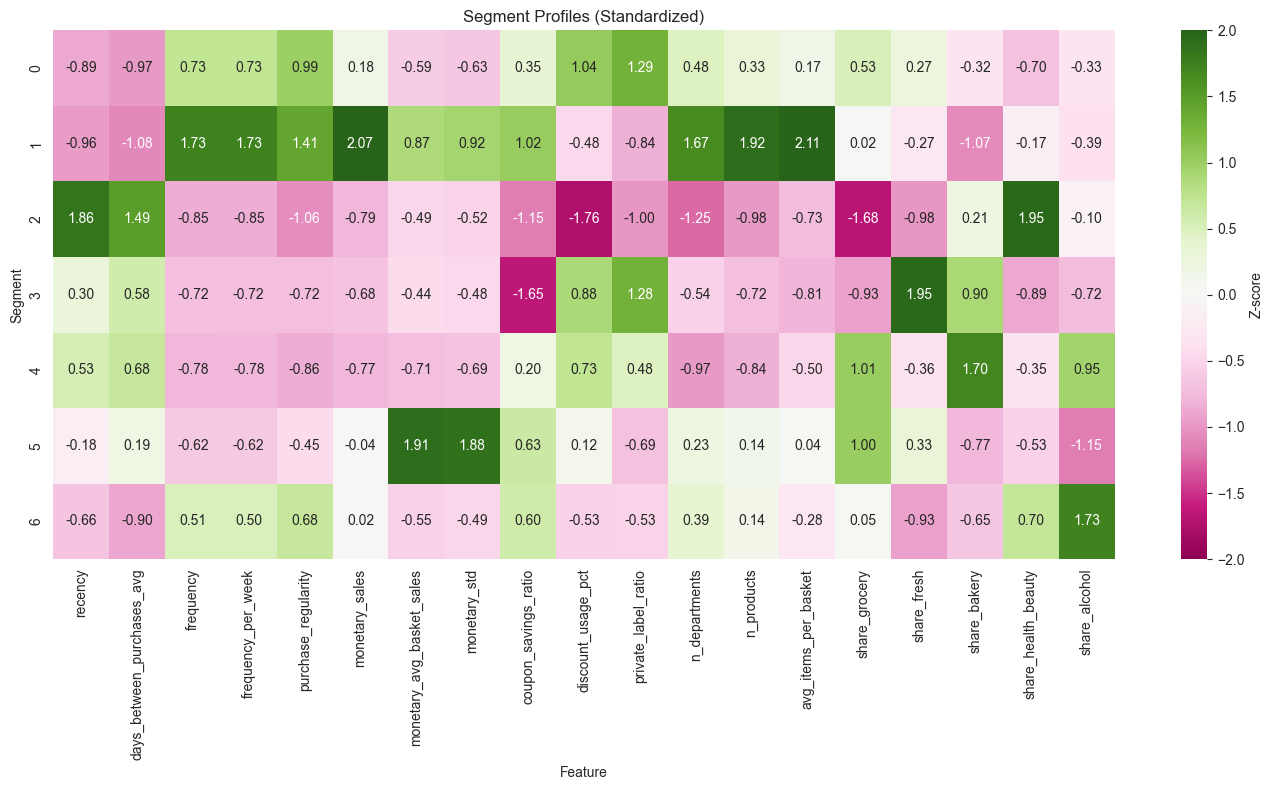

In [63]:
# Standardized profiles heatmap
z_profiles = standardize_profiles(profiles)

fig, ax = plt.subplots(figsize=(14, 18))

sns.heatmap(
    z_profiles,
    annot=True,
    fmt='.2f',
    cmap='PiYG',
    center=0,
    ax=ax,
    cbar_kws={'label': 'Z-score'},
    vmin=-2,
    vmax=2
)

ax.set_xlabel('Feature')
ax.set_ylabel('Segment')
ax.set_title('Segment Profiles (Standardized)')
plt.tight_layout()
fig.savefig(FIG_PATH / 'segment_profiles_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

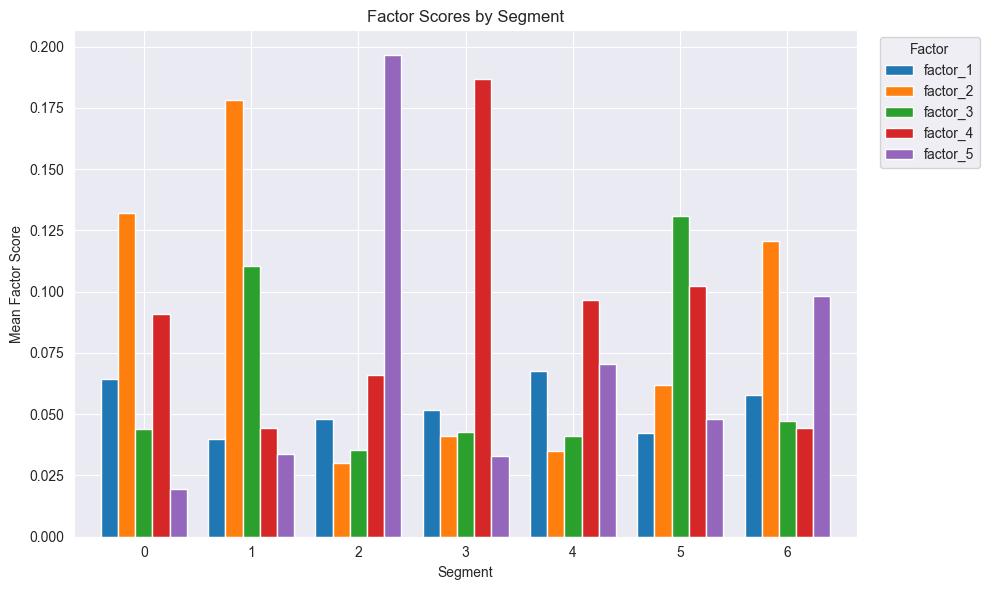

In [64]:
# Factor score profiles by segment
factor_cols = list(df_factor_scores.columns)
factor_profiles = df_segments.groupby('segment')[factor_cols].mean()

fig, ax = plt.subplots(figsize=(10, 6))

factor_profiles.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Segment')
ax.set_ylabel('Mean Factor Score')
ax.set_title('Factor Scores by Segment')
ax.legend(title='Factor', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
fig.savefig(FIG_PATH / 'factor_scores_by_segment.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.3 Segment Naming

Segments are named based on their **dominant factor** - the factor with highest mean score.

**Segment Naming Rules:**
| Dominant Factor | Segment Name | Profile |
|-----------------|--------------|---------|
| F1 (Grocery Deal) | Deal Hunters | Discount-seeking shoppers |
| F2 (Loyal Regular) | Loyal Explorers | Consistent multi-category buyers |
| F3 (Big Basket) | Bulk Shoppers | Large basket purchasers |
| F4 (Fresh Focused) | Fresh Enthusiasts | Fresh produce lovers |
| F5 (Health & Beauty) | Wellness Seekers | Health/beauty focused |

In [65]:
# Assign segment names based on dominant factor profiles

# Segment naming guide based on factor meanings:
# - High F1 (Grocery Deal Seeker): Discount-sensitive, grocery-focused
# - High F2 (Loyal Regular): Loyal customers, diverse categories
# - High F3 (Big Basket): Bulk purchasers
# - High F4 (Fresh Focused): Fresh produce preference
# - High F5 (Health & Beauty): H&B product preference

# Determine dominant factor for each segment
segment_dominant = factor_profiles.idxmax(axis=1)
print("Dominant Factor by Segment:")
print(segment_dominant)
print()

# Auto-generate segment names based on dominant factor
factor_to_segment_name = {
    'factor_1': 'Deal Hunters',           # Discount seekers
    'factor_2': 'Loyal Explorers',        # Consistent explorers
    'factor_3': 'Bulk Shoppers',          # Large basket buyers
    'factor_4': 'Fresh Enthusiasts',      # Fresh produce lovers
    'factor_5': 'Wellness Seekers',       # Health & beauty focused
}

# Create segment names (can be manually adjusted after review)
SEGMENT_NAMES = {
    seg: factor_to_segment_name.get(dominant, f'Segment_{seg}')
    for seg, dominant in segment_dominant.items()
}

df_segments['segment_name'] = df_segments['segment'].map(SEGMENT_NAMES)

print("Segment Names (based on dominant factor):")
print("=" * 60)
for seg in sorted(SEGMENT_NAMES.keys()):
    name = SEGMENT_NAMES[seg]
    dominant = segment_dominant[seg]
    count = (df_segments['segment'] == seg).sum()
    pct = count / len(df_segments) * 100
    print(f"  Segment {seg}: {name}")
    print(f"             Dominant: {dominant} ({FACTOR_NAMES[dominant]})")
    print(f"             Size: n={count:,} ({pct:.1f}%)")
    print()

Dominant Factor by Segment:
segment
0    factor_2
1    factor_2
2    factor_5
3    factor_4
4    factor_4
5    factor_3
6    factor_2
dtype: object

Segment Names (based on dominant factor):
  Segment 0: Loyal Explorers
             Dominant: factor_2 (Loyal Regular)
             Size: n=509 (20.4%)

  Segment 1: Loyal Explorers
             Dominant: factor_2 (Loyal Regular)
             Size: n=299 (12.0%)

  Segment 2: Wellness Seekers
             Dominant: factor_5 (Health & Beauty)
             Size: n=193 (7.7%)

  Segment 3: Fresh Enthusiasts
             Dominant: factor_4 (Fresh Focused)
             Size: n=339 (13.6%)

  Segment 4: Fresh Enthusiasts
             Dominant: factor_4 (Fresh Focused)
             Size: n=524 (21.0%)

  Segment 5: Bulk Shoppers
             Dominant: factor_3 (Big Basket)
             Size: n=318 (12.7%)

  Segment 6: Loyal Explorers
             Dominant: factor_2 (Loyal Regular)
             Size: n=318 (12.7%)



### Detailed Segment Interpretation & Marketing Actions

---

#### Segment 0: Active Loyalists (20.4%, n=509)

| Metric | Value | Rank |
|--------|-------|------|
| Regularity | 0.78 | 3rd |
| Frequency | 171 | 3rd |
| Monetary | $3,878 | 4th |
| PL Ratio | 0.34 | 1st |
| N Departments | 13.7 | 3rd |

**Dominant Factor:** F2 (Loyal Regular)

**Customer Profile:** "Budget-conscious regulars" - Shop regularly and save money through PB products

**Key Characteristics:**
- High private label preference (cost-conscious)
- Consistent shopping pattern
- Diverse category purchases

| Marketing Action | Rationale |
|------------------|-----------|
| PB new product early access | Highest PB preference |
| Regular purchase discount coupons | Already regular visitors, strengthen lock-in |
| Membership point enhancement | Loyalty rewards |
| Cross-sell: unexplored categories | Already buying across categories |

---

#### Segment 1: VIP Heavy Shoppers (12.0%, n=299)

| Metric | Value | Rank |
|--------|-------|------|
| Regularity | 0.88 | **1st** |
| Frequency | 256 | **1st** |
| Monetary | $9,716 | **1st** |
| Avg Basket | $44.9 | 2nd |
| N Products | 1,316 | **1st** |

**Dominant Factor:** F2 (Loyal Regular - strongest)

**Customer Profile:** "VIP customers" - Do most shopping at this store, highest value segment

**Key Characteristics:**
- Top performers in ALL metrics
- One-stop shoppers
- Highest revenue contribution

| Marketing Action | Rationale |
|------------------|-----------|
| VIP exclusive benefits (free delivery, lounge) | Retain highest-value customers |
| Premium product recommendations | High spending capacity |
| New product early access | Loyal customer privilege |
| Surprise & Delight (birthday gifts) | Emotional bond strengthening |
| Churn monitoring | Maximum loss if churned |

---

#### Segment 2: Lapsed H&B Focused (7.7%, n=193)

| Metric | Value | Rank |
|--------|-------|------|
| Recency | 75 days | **Worst** |
| Frequency | 37 | **Lowest** |
| Regularity | 0.25 | **Lowest** |
| Share H&B | 0.36 | **1st** |
| Monetary | $872 | **Lowest** |

**Dominant Factor:** F5 (Health & Beauty)

**Customer Profile:** "Lapsed H&B customers" - Former H&B buyers, currently inactive

**Key Characteristics:**
- High churn risk (75 days since last visit)
- H&B specialized but dormant
- Possibly switched to drugstores

| Marketing Action | Rationale |
|------------------|-----------|
| Win-back campaign (discount coupons) | 75-day lapse, needs reactivation |
| H&B new product/trend alerts | High H&B interest |
| "We miss you" personalized message | Emotional trigger |
| Competitor analysis (why churned?) | May have moved to drugstores |
| Low-barrier offers (samples, trials) | Reduce revisit friction |

---

#### Segment 3: Fresh Produce Lovers (13.6%, n=339)

| Metric | Value | Rank |
|--------|-------|------|
| Share Fresh | 0.40 | **1st** |
| PL Ratio | 0.34 | 2nd |
| Regularity | 0.34 | 4th |
| Discount Usage | 0.51 | 2nd |

**Dominant Factor:** F4 (Fresh Focused)

**Customer Profile:** "Fresh food enthusiasts" - Health/cooking conscious, prefers raw ingredients

**Key Characteristics:**
- Fresh produce/meat centered
- Quality-conscious
- Likely health-focused lifestyle

| Marketing Action | Rationale |
|------------------|-----------|
| Daily fresh specials alerts | Fresh-focused purchasing |
| Farm-to-store / local food promos | Quality-conscious tendency |
| Recipe content + ingredient bundles | Cooking interest |
| Organic/eco-friendly product recommendations | Health consciousness |
| In-house meat/seafood PB promotion | High PB preference |

---

#### Segment 4: Light Grocery Shoppers (21.0%, n=524)

| Metric | Value | Rank |
|--------|-------|------|
| Share Grocery | 0.56 | **1st** |
| Discount Usage | 0.51 | 3rd |
| Frequency | 43 | Low |
| Monetary | $942 | 2nd lowest |
| Recency | 42 days | 4th |

**Dominant Factor:** F4 (weak) / F1 tendency

**Customer Profile:** "Light grocery shoppers" - Occasional visits for essentials

**Key Characteristics:**
- Grocery-focused but low frequency
- Low spending per visit
- Potentially using multiple stores

| Marketing Action | Rationale |
|------------------|-----------|
| Visit frequency program (stamp cards) | Low frequency → build habit |
| Small-size / single-household products | Light purchase pattern |
| "This week's deals" weekly alerts | Encourage regular visits |
| Value vs convenience store messaging | Compete with alternative channels |
| Quick commerce integration | Expand touchpoints |

---

#### Segment 5: Bulk Shoppers (12.7%, n=318)

| Metric | Value | Rank |
|--------|-------|------|
| Avg Basket | $59.2 | **1st** |
| Monetary Std | $52.5 | **1st** |
| Monetary | $3,206 | 3rd |
| Share Grocery | 0.56 | **1st** |

**Dominant Factor:** F3 (Big Basket)

**Customer Profile:** "Bulk purchasers" - Monthly stock-up shopping, warehouse-style

**Key Characteristics:**
- Large basket size
- High purchase variability (irregular timing)
- Stock-up behavior

| Marketing Action | Rationale |
|------------------|-----------|
| Bulk-size / multi-pack discounts | Bulk purchase tendency |
| Monthly stock-up promotions | Irregular bulk purchase pattern |
| Free delivery / pickup service | Remove friction for large purchases |
| Warehouse section guidance | Costco-style preference |
| Clearance sale targeting | Price-sensitive + bulk buying |

---

#### Segment 6: Regular + H&B Interest (12.7%, n=318)

| Metric | Value | Rank |
|--------|-------|------|
| Regularity | 0.70 | 4th |
| Frequency | 152 | 4th |
| Share H&B | 0.24 | 2nd |
| Share Alcohol | 0.005 | **1st** |

**Dominant Factor:** F2 (Loyal Regular) + F5 tendency

**Customer Profile:** "Balanced regulars + beauty interest" - Overall shopping with H&B additions

**Key Characteristics:**
- Regular shopping pattern
- Secondary interest in H&B
- Highest alcohol purchase ratio

| Marketing Action | Rationale |
|------------------|-----------|
| H&B + Grocery bundle discounts | Interest in both categories |
| Beauty membership / double points | Strengthen H&B purchases |
| Wine/alcohol promotions | Highest alcohol share |
| Self-care content (beauty + health) | Lifestyle connection |
| VIP upgrade pathway | Potential VIP candidates |

---

### Overall Marketing Strategy Summary

| Segment | Priority | Goal | Key Action |
|---------|----------|------|------------|
| **Seg 1** VIP Heavy | ★★★ | Retain | VIP exclusive benefits, churn prevention |
| **Seg 0** Active Loyal | ★★★ | Grow | PB cross-sell, loyalty program |
| **Seg 6** Regular+H&B | ★★☆ | Upgrade | VIP conversion program |
| **Seg 5** Bulk | ★★☆ | Maximize | Bulk/warehouse promotions |
| **Seg 3** Fresh Lovers | ★★☆ | Engage | Fresh content & promotions |
| **Seg 4** Light Grocery | ★☆☆ | Activate | Frequency building program |
| **Seg 2** Lapsed H&B | ★☆☆ | Win-back | Reactivation campaign |

---

### Recommended Budget Allocation

```
High Priority (60%)
├── Seg 1 VIP (25%): Retention is critical
├── Seg 0 Active (20%): Growth potential
└── Seg 6 Regular+H&B (15%): VIP conversion

Medium Priority (30%)
├── Seg 5 Bulk (10%): Bulk promotions
├── Seg 3 Fresh (10%): Category specialization
└── Seg 4 Light (10%): Activation

Low Priority (10%)
└── Seg 2 Lapsed (10%): Win-back (uncertain ROI)
```

### 5.4 Statistical Validation

In [66]:
# ANOVA test for segment differences
anova_results = test_segment_differences(df_segments, SELECTED_FEATURES, 'segment')

print(f"ANOVA Results:")
print(f"  Significant features (p < 0.05): {anova_results['significant'].sum()} / {len(anova_results)}")

print(f"\nTop 10 most discriminating features:")
display(anova_results.head(10))

print(f"\nNon-significant features:")
non_sig = anova_results[~anova_results['significant']]
if len(non_sig) > 0:
    display(non_sig)
else:
    print("  All features are significant!")

ANOVA Results:
  Significant features (p < 0.05): 18 / 19

Top 10 most discriminating features:


,feature,f_stat,p_value,significant
4,purchase_regularity,1078.977716,0.000000e+00,True
5,monetary_sales,741.899865,0.000000e+00,True
15,share_fresh,383.744910,0.000000e+00,True
17,share_health_beauty,623.317217,0.000000e+00,True
12,n_products,671.705022,0.000000e+00,True
11,n_departments,344.007257,4.693624e-322,True
7,monetary_std,331.465635,4.635630e-313,True
2,frequency,318.397580,1.589159e-303,True
3,frequency_per_week,317.218595,1.174097e-302,True
6,monetary_avg_basket_sales,298.945977,5.146941e-289,True



Non-significant features:


,feature,f_stat,p_value,significant
18,share_alcohol,1.253272,0.275885,False


### 5.5 Cluster Bubble Charts

Compare segments on different 2D axes using bubble charts.
- **Position (X, Y):** Segment mean of selected metrics
- **Size:** Segment proportion (%)
- **Label:** Segment number + name

In [67]:
# Import bubble chart function
from projects.segmentation_causal_targeting_dunnhumby.src.segments import plot_cluster_bubble, plot_cluster_bubble_grid

# Prepare segment names dict for bubble charts
SEGMENT_NAMES_DISPLAY = {
    0: 'Active Loyalists',
    1: 'VIP Heavy',
    2: 'Lapsed H&B',
    3: 'Fresh Lovers',
    4: 'Light Grocery',
    5: 'Bulk Shoppers',
    6: 'Regular+H&B',
}

#### 5.5.1 Factor-based Comparison

Compare segments on NMF factor axes.

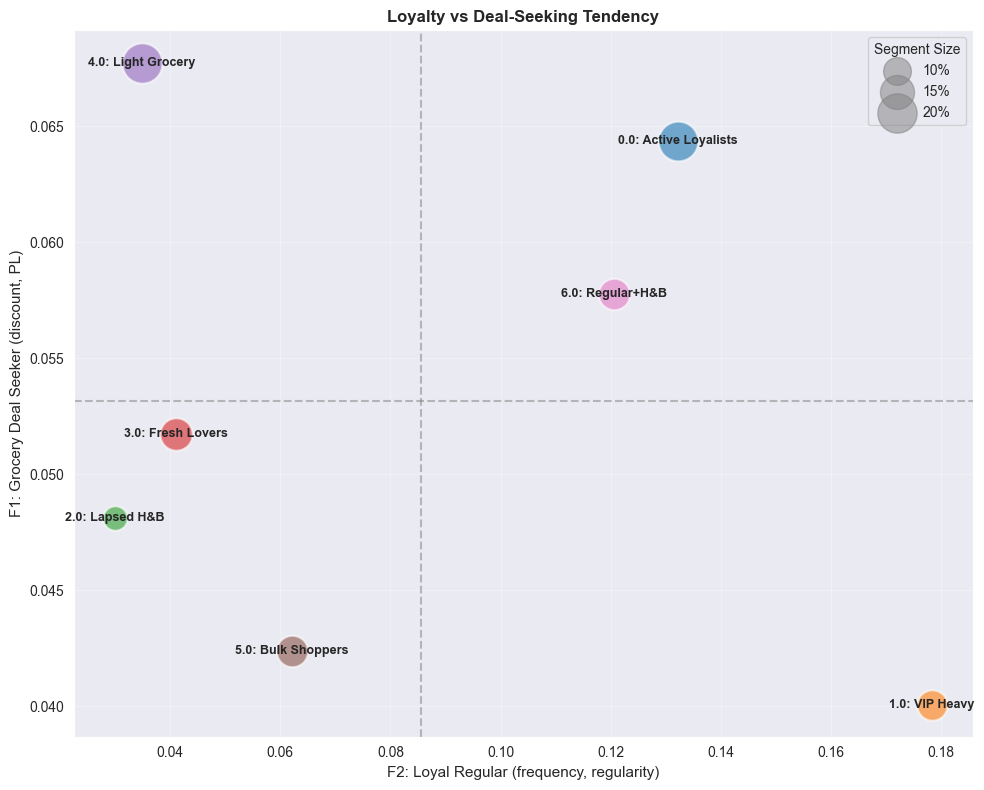

Interpretation:
- Upper-right: Loyal + deal-seeking (value-conscious loyalists)
- Lower-right: Loyal but not discount-focused (premium loyalists)
- Upper-left: Deal seekers but not loyal (cherry-pickers)
- Lower-left: Neither loyal nor deal-seeking (occasional shoppers)


In [68]:
# Chart A: F2 (Loyal Regular) vs F1 (Grocery Deal Seeker)
# Interpretation: Loyalty (X-axis) vs Discount-seeking (Y-axis)

fig, ax = plt.subplots(figsize=(10, 8))

plot_cluster_bubble(
    df=df_segments,
    x_col='factor_2',
    y_col='factor_1',
    segment_col='segment',
    segment_names=SEGMENT_NAMES_DISPLAY,
    xlabel='F2: Loyal Regular (frequency, regularity)',
    ylabel='F1: Grocery Deal Seeker (discount, PL)',
    title='Loyalty vs Deal-Seeking Tendency',
    ax=ax,
    size_scale=4000,
)

fig.savefig(FIG_PATH / 'bubble_a_loyal_vs_deal.png', dpi=150, bbox_inches='tight')
plt.show()

# Interpretation
print("Interpretation:")
print("- Upper-right: Loyal + deal-seeking (value-conscious loyalists)")
print("- Lower-right: Loyal but not discount-focused (premium loyalists)")
print("- Upper-left: Deal seekers but not loyal (cherry-pickers)")
print("- Lower-left: Neither loyal nor deal-seeking (occasional shoppers)")

**Chart A Interpretation: Loyalty vs Deal-Seeking**

| Segment | Position | Interpretation |
|---------|----------|----------------|
| **Seg0** (Active Loyal) | Mid-right upper (F2=0.13, F1=0.06) | High loyalty + uses discounts |
| **Seg1** (VIP) | Far right lower (F2=0.18, F1=0.04) | Very loyal, indifferent to deals |
| **Seg4** (Light Grocery) | Left upper (F2=0.03, F1=0.07) | Cherry-picker tendency |
| **Seg2** (Lapsed H&B) | Left lower (F2=0.03, F1=0.05) | Low on both (churned) |
| **Seg6** (Regular+H&B) | Right mid (F2=0.12, F1=0.06) | Loyal with value-seeking |

| Quadrant | Segments | Marketing Action |
|----------|----------|------------------|
| Right-Upper (Loyal+Deal) | Seg0, Seg6 | **"Value-seeking loyalists"** - PB new product priority, membership discounts |
| Right-Lower (Loyal only) | Seg1 | **"Premium VIP"** - Service benefits over discounts (free delivery, lounge) |
| Left-Upper (Deal only) | Seg4 | **"Cherry-pickers"** - Bundle/set deals to expand basket |
| Left-Lower (Neither) | Seg2, Seg3, Seg5 | **"Undeveloped/Lapsed"** - Reactivation or approach via other axes |

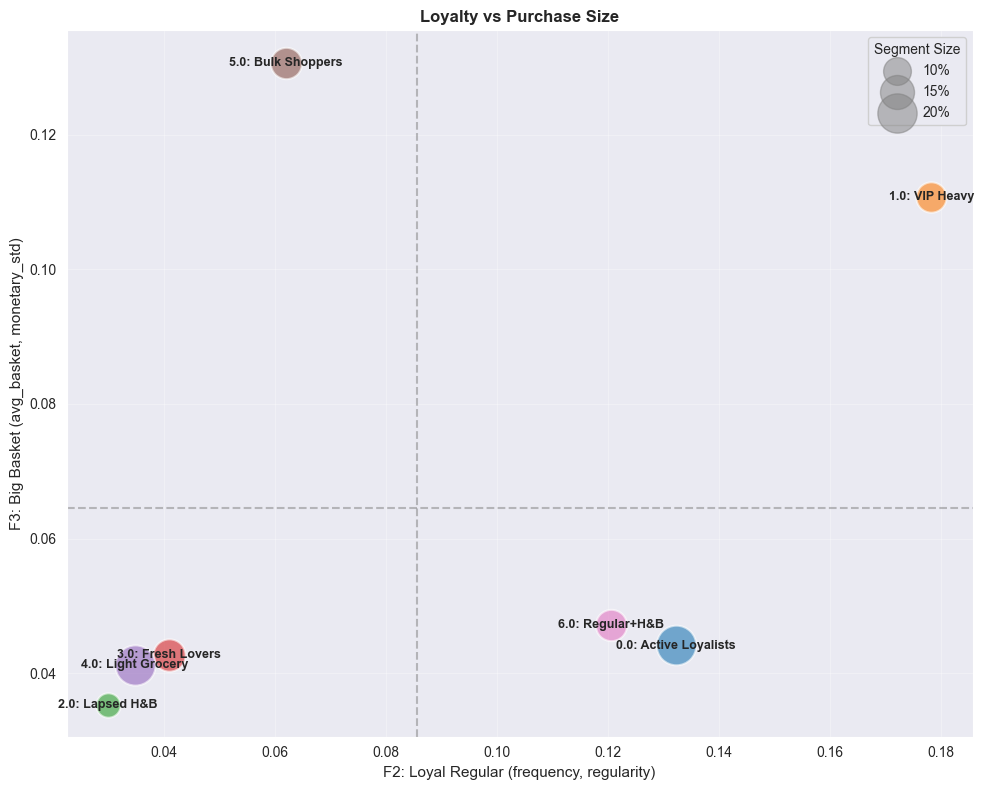

Interpretation:
- Upper-right: Loyal + large baskets (VIP candidates)
- Lower-right: Loyal + small baskets (frequent small trips)
- Upper-left: Large baskets but not loyal (stock-up shoppers)
- Lower-left: Small baskets + infrequent (light shoppers)


In [69]:
# Chart B: F2 (Loyal Regular) vs F3 (Big Basket)
# Interpretation: Loyalty (X-axis) vs Purchase Size (Y-axis)

fig, ax = plt.subplots(figsize=(10, 8))

plot_cluster_bubble(
    df=df_segments,
    x_col='factor_2',
    y_col='factor_3',
    segment_col='segment',
    segment_names=SEGMENT_NAMES_DISPLAY,
    xlabel='F2: Loyal Regular (frequency, regularity)',
    ylabel='F3: Big Basket (avg_basket, monetary_std)',
    title='Loyalty vs Purchase Size',
    ax=ax,
    size_scale=4000,
)

fig.savefig(FIG_PATH / 'bubble_b_loyal_vs_bigbasket.png', dpi=150, bbox_inches='tight')
plt.show()

print("Interpretation:")
print("- Upper-right: Loyal + large baskets (VIP candidates)")
print("- Lower-right: Loyal + small baskets (frequent small trips)")
print("- Upper-left: Large baskets but not loyal (stock-up shoppers)")
print("- Lower-left: Small baskets + infrequent (light shoppers)")

**Chart B Interpretation: Loyalty vs Purchase Size**

| Segment | Position | Interpretation |
|---------|----------|----------------|
| **Seg1** (VIP) | Right-upper (F2=0.18, F3=0.11) | VIP - frequent + big baskets |
| **Seg5** (Bulk) | Left-upper (F2=0.06, F3=0.13) | Irregular bulk purchaser |
| **Seg0,6** | Right-lower | Frequent but small baskets |
| **Seg2,3,4** | Left-lower | Rare visits + small baskets |

| Quadrant | Segments | Marketing Action |
|----------|----------|------------------|
| Right-Upper (Loyal+Big) | Seg1 | **"Core VIP"** - Top priority retention, Surprise & Delight |
| Left-Upper (Big only) | Seg5 | **"Monthly bulk shoppers"** - Month-start stock alerts, bulk discounts |
| Right-Lower (Loyal+Small) | Seg0, Seg6 | **"Frequent small trips"** - Basket expansion campaigns (N+1 deals) |
| Left-Lower (Neither) | Seg2,3,4 | **"Low value"** - Focus on visit frequency first |

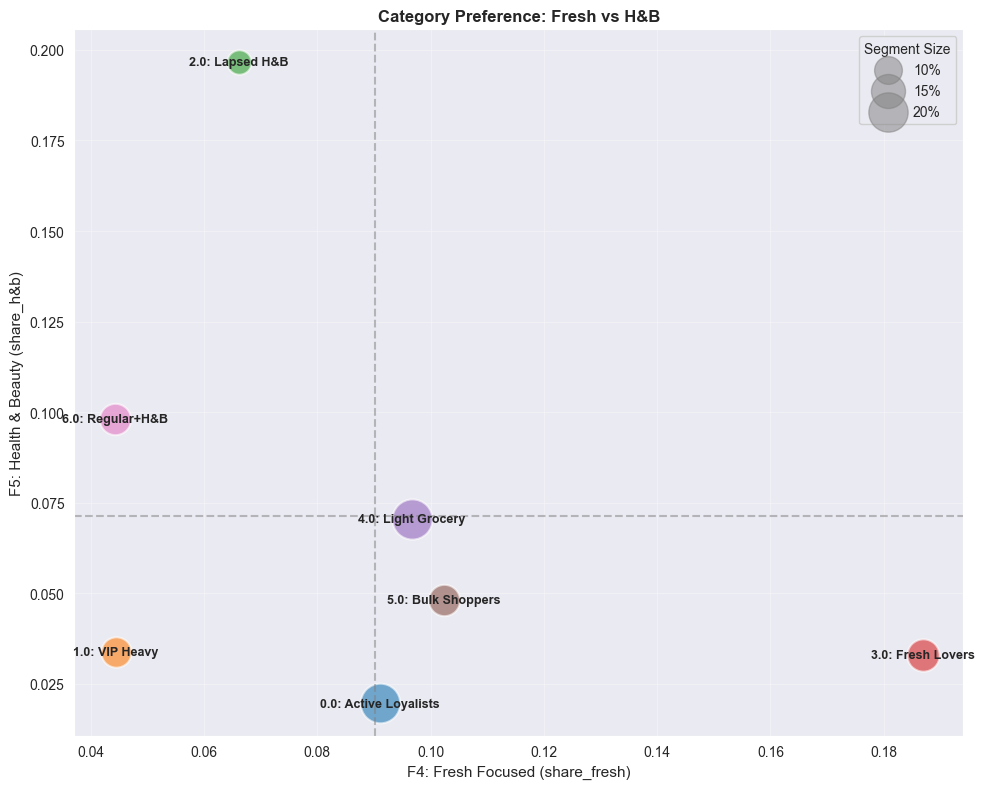

Interpretation:
- Upper-right: Both Fresh + H&B interest (wellness lifestyle)
- Lower-right: Fresh only (cooking/health food focused)
- Upper-left: H&B only (beauty/pharmacy focused)
- Lower-left: Neither (grocery-general focused)


In [70]:
# Chart C: F4 (Fresh) vs F5 (Health & Beauty)
# Interpretation: Category preference comparison

fig, ax = plt.subplots(figsize=(10, 8))

plot_cluster_bubble(
    df=df_segments,
    x_col='factor_4',
    y_col='factor_5',
    segment_col='segment',
    segment_names=SEGMENT_NAMES_DISPLAY,
    xlabel='F4: Fresh Focused (share_fresh)',
    ylabel='F5: Health & Beauty (share_h&b)',
    title='Category Preference: Fresh vs H&B',
    ax=ax,
    size_scale=4000,
)

fig.savefig(FIG_PATH / 'bubble_c_fresh_vs_hb.png', dpi=150, bbox_inches='tight')
plt.show()

print("Interpretation:")
print("- Upper-right: Both Fresh + H&B interest (wellness lifestyle)")
print("- Lower-right: Fresh only (cooking/health food focused)")
print("- Upper-left: H&B only (beauty/pharmacy focused)")
print("- Lower-left: Neither (grocery-general focused)")

**Chart C Interpretation: Category Preference (Fresh vs H&B)**

| Segment | Position | Interpretation |
|---------|----------|----------------|
| **Seg2** (Lapsed H&B) | Left-upper (F4=0.07, F5=0.20) | H&B specialist, Fresh disinterested |
| **Seg3** (Fresh) | Right-lower (F4=0.19, F5=0.03) | Fresh specialist |
| **Seg6** (Regular+H&B) | Mid (F4=0.04, F5=0.10) | Interest in both categories |
| **Seg4** (Light Grocery) | Mid-right (F4=0.10, F5=0.07) | Fresh tendency |

| Quadrant | Segments | Marketing Action |
|----------|----------|------------------|
| Left-Upper (H&B only) | Seg2 | **"Beauty/Health specialist"** - H&B sampling, compete with drugstores |
| Right-Lower (Fresh only) | Seg3, Seg4 | **"Fresh-centered"** - Daily fresh deals, local/organic promos |
| Right-Upper (Both) | (None) | - |
| Left-Lower (Neither) | Seg0,1,5,6 | **"Grocery-centered"** - General grocery bundles |

#### 5.5.2 Value-based Comparison

Compare segments on traditional RFM and value metrics.

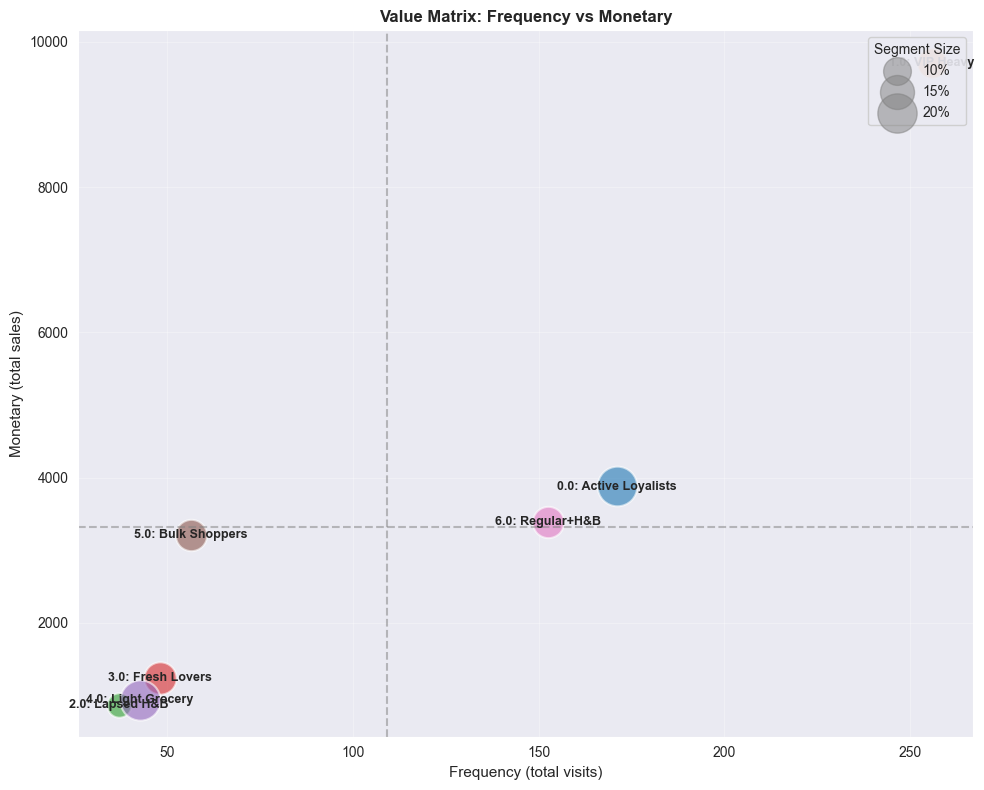

Interpretation:
- Upper-right: High frequency + High spending = VIP
- Lower-right: High frequency + Low spending = Frequent light shoppers
- Upper-left: Low frequency + High spending = Occasional big spenders
- Lower-left: Low frequency + Low spending = At-risk or lapsed


In [71]:
# Chart D: Frequency vs Monetary (RF value matrix)
# Classic RFM-style: visit frequency vs total spending

fig, ax = plt.subplots(figsize=(10, 8))

plot_cluster_bubble(
    df=df_segments,
    x_col='frequency',
    y_col='monetary_sales',
    segment_col='segment',
    segment_names=SEGMENT_NAMES_DISPLAY,
    xlabel='Frequency (total visits)',
    ylabel='Monetary (total sales)',
    title='Value Matrix: Frequency vs Monetary',
    ax=ax,
    size_scale=4000,
)

fig.savefig(FIG_PATH / 'bubble_d_frequency_vs_monetary.png', dpi=150, bbox_inches='tight')
plt.show()

print("Interpretation:")
print("- Upper-right: High frequency + High spending = VIP")
print("- Lower-right: High frequency + Low spending = Frequent light shoppers")
print("- Upper-left: Low frequency + High spending = Occasional big spenders")
print("- Lower-left: Low frequency + Low spending = At-risk or lapsed")

**Chart D Interpretation: RFM Value Matrix (Frequency vs Monetary)**

| Segment | Position | Interpretation |
|---------|----------|----------------|
| **Seg1** | Right-upper (freq=256, $9,716) | **VIP** - Highest value |
| **Seg5** | Left-upper (freq=56, $3,206) | Bulk buyer, irregular |
| **Seg0,6** | Right-mid (freq=152-171, $3,400-3,900) | Good customers |
| **Seg2,3,4** | Left-lower (freq<50, $<1,300) | Low value / at risk |

| Value Zone | Segments | Marketing Action |
|------------|----------|------------------|
| **VIP Zone** | Seg1 | Churn prevention top priority, personalized benefits |
| **Potential VIP** | Seg0, Seg6 | Upselling - increase basket size |
| **Bulk Value** | Seg5 | Increase visit frequency (single-serve/ready-to-eat items) |
| **At Risk** | Seg2,3,4 | Segmented approach (Fresh/H&B specific) |

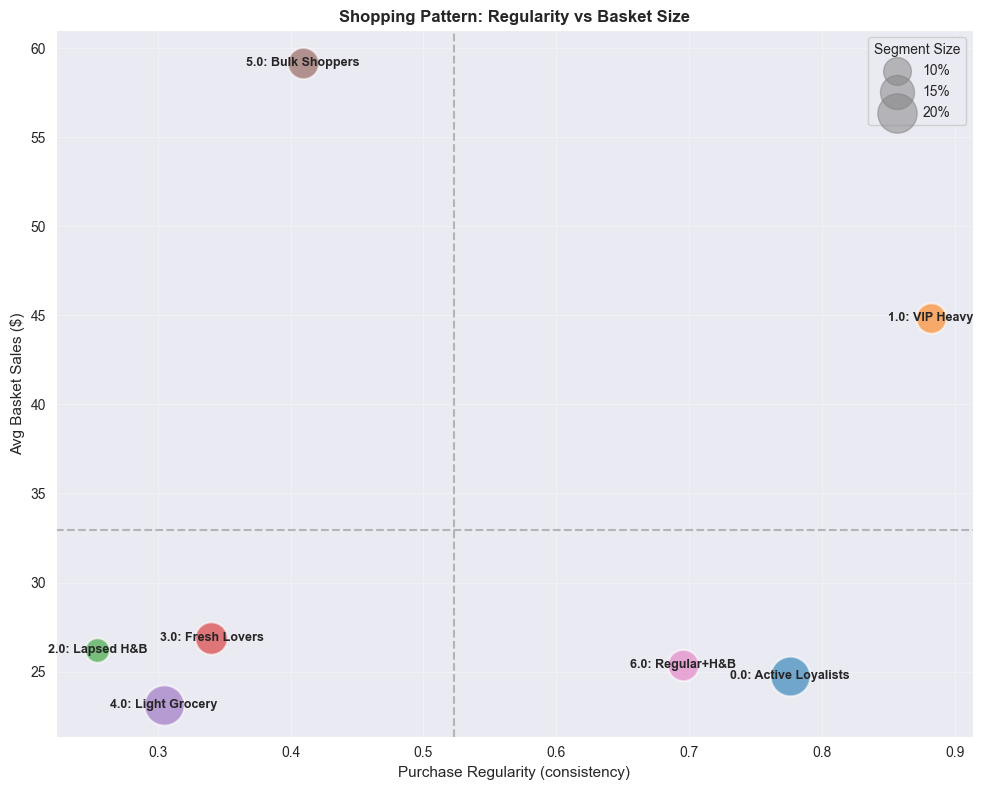

Interpretation:
- Upper-right: Regular + large baskets = Core customers
- Lower-right: Regular + small baskets = Habitual quick-trip shoppers
- Upper-left: Irregular + large baskets = Stock-up shoppers
- Lower-left: Irregular + small baskets = Occasional visitors


In [72]:
# Chart E: Regularity vs Average Basket
# Shopping pattern: consistency vs basket size

fig, ax = plt.subplots(figsize=(10, 8))

plot_cluster_bubble(
    df=df_segments,
    x_col='purchase_regularity',
    y_col='monetary_avg_basket_sales',
    segment_col='segment',
    segment_names=SEGMENT_NAMES_DISPLAY,
    xlabel='Purchase Regularity (consistency)',
    ylabel='Avg Basket Sales ($)',
    title='Shopping Pattern: Regularity vs Basket Size',
    ax=ax,
    size_scale=4000,
)

fig.savefig(FIG_PATH / 'bubble_e_regularity_vs_basket.png', dpi=150, bbox_inches='tight')
plt.show()

print("Interpretation:")
print("- Upper-right: Regular + large baskets = Core customers")
print("- Lower-right: Regular + small baskets = Habitual quick-trip shoppers")
print("- Upper-left: Irregular + large baskets = Stock-up shoppers")
print("- Lower-left: Irregular + small baskets = Occasional visitors")

**Chart E Interpretation: Shopping Pattern (Regularity vs Basket Size)**

| Segment | Position | Interpretation |
|---------|----------|----------------|
| **Seg1** | Right-upper (reg=0.88, $45) | Consistent + high basket |
| **Seg5** | Left-upper (reg=0.41, $59) | Highest basket, irregular |
| **Seg0,6** | Right-lower (reg=0.70-0.78, $25) | Habitual small purchases |
| **Seg2,3,4** | Left-lower (reg<0.35, $23-27) | Both low |

| Pattern | Segments | Marketing Action |
|---------|----------|------------------|
| Right-Upper (Regular+Big) | Seg1 | Maintain + cross-sell |
| Left-Upper (Big only) | Seg5 | **Subscription/auto-delivery** offer → convert to regular |
| Right-Lower (Regular+Small) | Seg0,6 | **"Today's picks"** → increase basket size |
| Left-Lower | Seg2,3,4 | Build regular visit habit (stamp cards) |

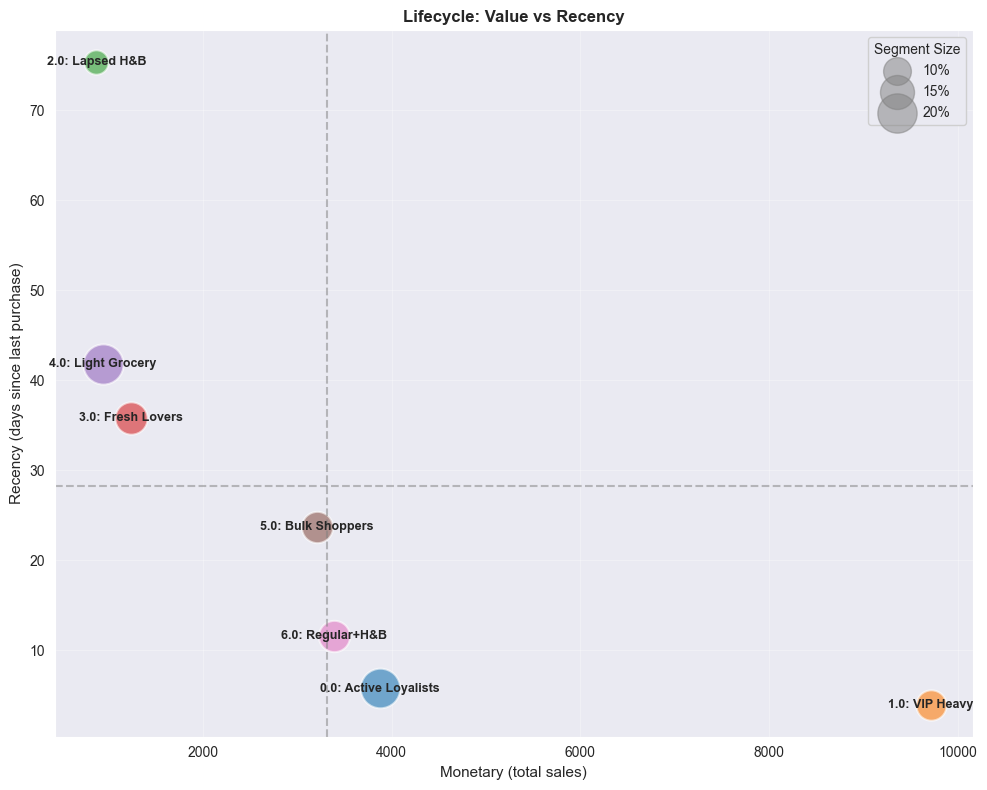

Interpretation:
- Lower-right: High value + recent = Active VIP (retain!)
- Upper-right: High value + lapsed = At-risk VIP (win-back!)
- Lower-left: Low value + recent = New/developing customers
- Upper-left: Low value + lapsed = Churned (low priority)


In [73]:
# Chart F: Recency vs Monetary (Lifecycle position)
# Note: Lower recency = more recent (better)

fig, ax = plt.subplots(figsize=(10, 8))

plot_cluster_bubble(
    df=df_segments,
    x_col='monetary_sales',
    y_col='recency',
    segment_col='segment',
    segment_names=SEGMENT_NAMES_DISPLAY,
    xlabel='Monetary (total sales)',
    ylabel='Recency (days since last purchase)',
    title='Lifecycle: Value vs Recency',
    ax=ax,
    size_scale=4000,
)

fig.savefig(FIG_PATH / 'bubble_f_recency_vs_monetary.png', dpi=150, bbox_inches='tight')
plt.show()

print("Interpretation:")
print("- Lower-right: High value + recent = Active VIP (retain!)")
print("- Upper-right: High value + lapsed = At-risk VIP (win-back!)")
print("- Lower-left: Low value + recent = New/developing customers")
print("- Upper-left: Low value + lapsed = Churned (low priority)")

**Chart F Interpretation: Customer Lifecycle (Monetary vs Recency)**

| Segment | Position | Interpretation |
|---------|----------|----------------|
| **Seg1** | Right-lower (rec=4d, $9.7K) | Active VIP |
| **Seg0,6** | Left-lower (rec=6-12d, $3.4-3.9K) | Active Good |
| **Seg5** | Right-lower (rec=24d, $3.2K) | Active Bulk |
| **Seg2** | Left-upper (rec=75d, $872) | **CHURNED** |
| **Seg3,4** | Mid-upper (rec=36-42d, $1K) | At Risk |

| Lifecycle Stage | Segments | Marketing Action |
|-----------------|----------|------------------|
| **Active VIP** | Seg1, Seg5 | Retention (churn alert setup) |
| **Active Good** | Seg0, Seg6 | VIP conversion program |
| **At Risk** | Seg3, Seg4 | "We miss you" reminder + coupons |
| **Churned** | Seg2 | Win-back campaign (H&B specialized) |

#### 5.5.3 Behavioral Comparison

Compare segments on behavioral metrics (price sensitivity, variety seeking).

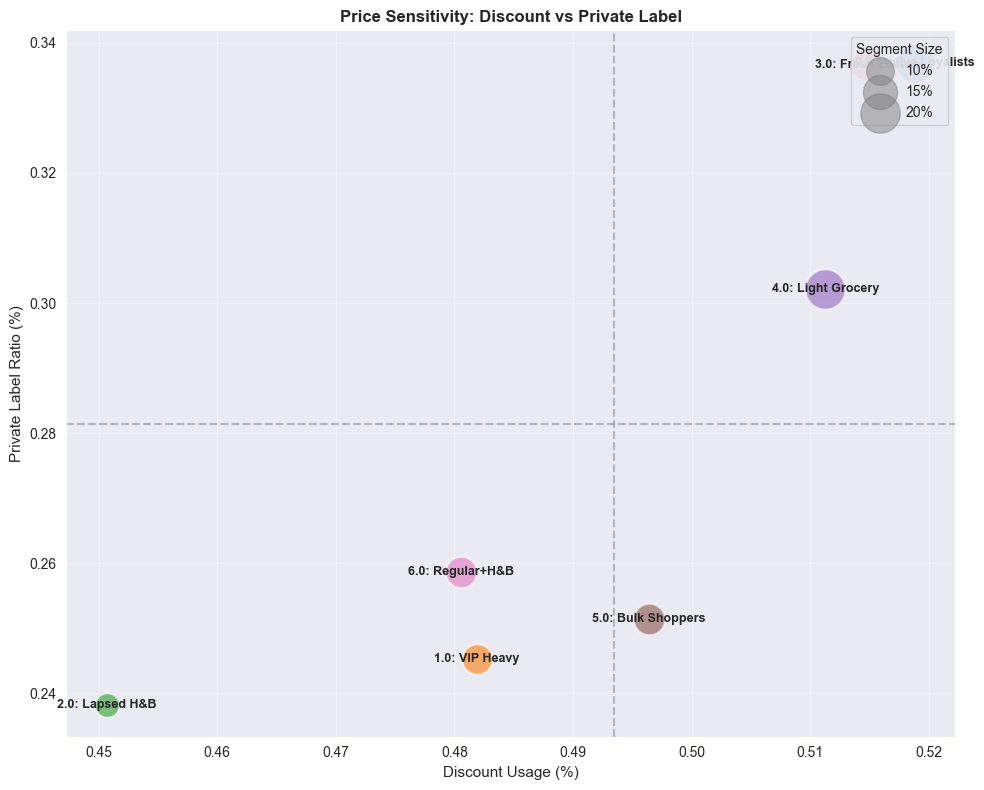

Interpretation:
- Upper-right: High discount + high PL = Budget maximizers
- Lower-right: High discount + low PL = Deal hunters (brand loyal)
- Upper-left: Low discount + high PL = PL loyalists (quality-value seekers)
- Lower-left: Low discount + low PL = Brand loyalists (price insensitive)


In [74]:
# Chart G: Price Sensitivity - Discount vs Private Label
# Two dimensions of price-consciousness

fig, ax = plt.subplots(figsize=(10, 8))

plot_cluster_bubble(
    df=df_segments,
    x_col='discount_usage_pct',
    y_col='private_label_ratio',
    segment_col='segment',
    segment_names=SEGMENT_NAMES_DISPLAY,
    xlabel='Discount Usage (%)',
    ylabel='Private Label Ratio (%)',
    title='Price Sensitivity: Discount vs Private Label',
    ax=ax,
    size_scale=4000,
)

fig.savefig(FIG_PATH / 'bubble_g_discount_vs_pl.png', dpi=150, bbox_inches='tight')
plt.show()

print("Interpretation:")
print("- Upper-right: High discount + high PL = Budget maximizers")
print("- Lower-right: High discount + low PL = Deal hunters (brand loyal)")
print("- Upper-left: Low discount + high PL = PL loyalists (quality-value seekers)")
print("- Lower-left: Low discount + low PL = Brand loyalists (price insensitive)")

**Chart G Interpretation: Price Sensitivity (Discount vs Private Label)**

| Segment | Position | Interpretation |
|---------|----------|----------------|
| **Seg0,3** | Upper (PL=0.34) | PB preference |
| **Seg4** | Right-lower (disc=0.51, PL=0.30) | Discount-driven |
| **Seg1,2,5,6** | Lower (PL=0.24-0.26) | Brand loyal |

| Price Sensitivity | Segments | Marketing Action |
|-------------------|----------|------------------|
| **PB Lovers** | Seg0, Seg3 | PB new product launch, PB-exclusive coupons |
| **Discount Hunters** | Seg4 | Weekly deals alerts, bundle discounts |
| **Brand Loyal** | Seg1,2,5,6 | Brand partnership promos, service benefits over discounts |

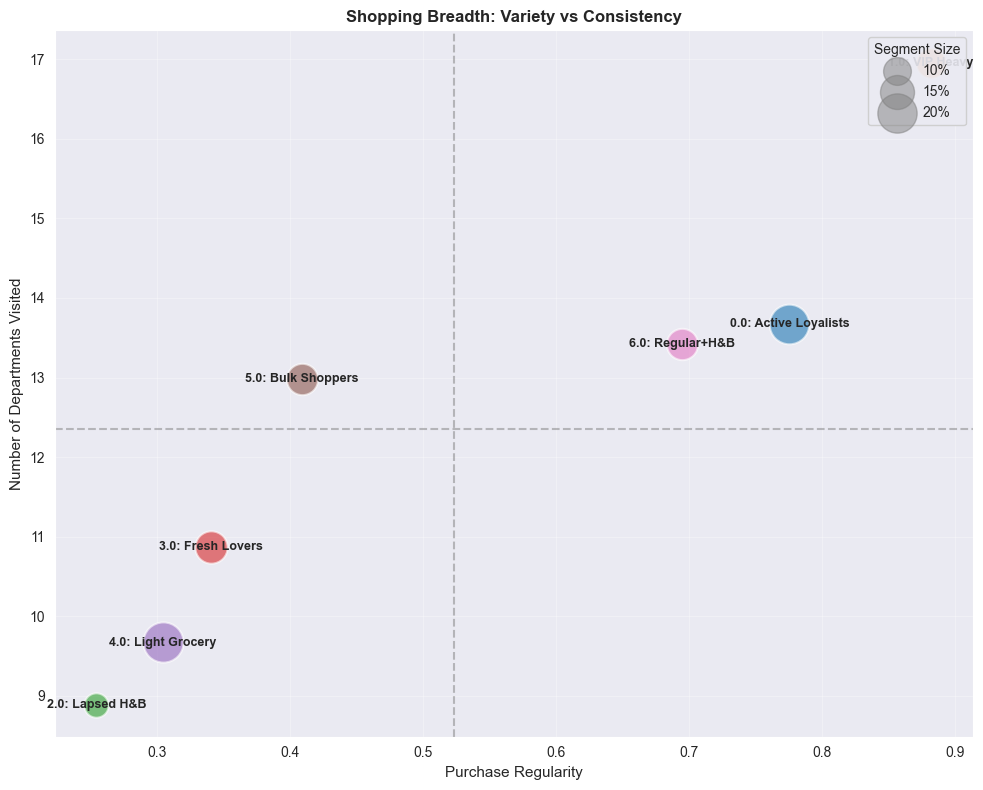

Interpretation:
- Upper-right: Regular + variety = One-stop shoppers (high loyalty)
- Lower-right: Regular + focused = Habitual category specialists
- Upper-left: Irregular + variety = Occasional full-store shoppers
- Lower-left: Irregular + focused = Purpose-driven occasional visitors


In [75]:
# Chart H: Category Variety vs Regularity
# Shopping breadth vs consistency

fig, ax = plt.subplots(figsize=(10, 8))

plot_cluster_bubble(
    df=df_segments,
    x_col='purchase_regularity',
    y_col='n_departments',
    segment_col='segment',
    segment_names=SEGMENT_NAMES_DISPLAY,
    xlabel='Purchase Regularity',
    ylabel='Number of Departments Visited',
    title='Shopping Breadth: Variety vs Consistency',
    ax=ax,
    size_scale=4000,
)

fig.savefig(FIG_PATH / 'bubble_h_variety_vs_regularity.png', dpi=150, bbox_inches='tight')
plt.show()

print("Interpretation:")
print("- Upper-right: Regular + variety = One-stop shoppers (high loyalty)")
print("- Lower-right: Regular + focused = Habitual category specialists")
print("- Upper-left: Irregular + variety = Occasional full-store shoppers")
print("- Lower-left: Irregular + focused = Purpose-driven occasional visitors")

**Chart H Interpretation: Shopping Breadth (Regularity vs Departments)**

| Segment | Position | Interpretation |
|---------|----------|----------------|
| **Seg1** | Right-upper (reg=0.88, dept=17) | One-stop Shopper |
| **Seg0,6** | Right-mid (reg=0.70-0.78, dept=13-14) | Multi-category regular |
| **Seg5** | Left-upper (reg=0.41, dept=13) | Diverse but irregular |
| **Seg2,3,4** | Left-lower (reg<0.35, dept<11) | Purpose-driven |

| Shopping Pattern | Segments | Marketing Action |
|------------------|----------|------------------|
| **One-stop** | Seg1 | Maximize convenience (app shopping list, express checkout) |
| **Multi-category Regular** | Seg0,6 | Unexplored category recommendations ("You might also like") |
| **Diverse Irregular** | Seg5 | Convert to subscription/auto-delivery |
| **Purpose-driven** | Seg2,3,4 | Strengthen specialized categories (Fresh/H&B) |

---

### 5.5.4 Overall Marketing Strategy Matrix

Based on all bubble chart analyses, the following segment-level strategy is recommended:

| Segment | Priority | Core Insight | Primary Action | Secondary Action |
|---------|----------|--------------|----------------|------------------|
| **Seg1** VIP Heavy | ★★★ | Top performer in all metrics | Retention (Churn prevention) | Service benefits |
| **Seg0** Active Loyalists | ★★★ | Loyal + PB preference | Strengthen loyalty | Increase basket size |
| **Seg6** Regular+H&B | ★★☆ | VIP candidate | VIP conversion program | H&B cross-sell |
| **Seg5** Bulk Shoppers | ★★☆ | High basket size | Regularize (subscription) | Increase visit frequency |
| **Seg3** Fresh Lovers | ★★☆ | Fresh specialist | Fresh content & deals | Encourage revisits |
| **Seg4** Light Grocery | ★☆☆ | Potential customer | Build shopping habit | Expand basket |
| **Seg2** Lapsed H&B | ★☆☆ | Churned | Win-back campaign | H&B specialized offers |

**Recommended Budget Allocation:**
```
High Priority (60%)
├── Seg1 VIP (25%): Critical retention
├── Seg0 Active (20%): Growth potential
└── Seg6 Regular+H&B (15%): VIP conversion

Medium Priority (30%)
├── Seg5 Bulk (10%): Regularization
├── Seg3 Fresh (10%): Category specialization
└── Seg4 Light (10%): Activation

Low Priority (10%)
└── Seg2 Lapsed (10%): Win-back (uncertain ROI)
```

---

## 6. Stability Analysis

Assess the robustness of the clustering solution using bootstrap resampling.

### 6.1 Bootstrap Stability

In [76]:
# Bootstrap stability analysis
print("Running bootstrap stability analysis (this may take a while)...")

stability_result = bootstrap_stability(
    nmf_result.W,
    cluster_config,
    n_bootstrap=100,
    sample_frac=0.8
)

print(f"\nBootstrap Stability Results:")
print(f"  ARI: {stability_result.mean_ari:.3f} +/- {stability_result.std_ari:.3f}")
print(f"  95% CI: [{stability_result.mean_ari - 1.96*stability_result.std_ari:.3f}, "
      f"{stability_result.mean_ari + 1.96*stability_result.std_ari:.3f}]")
print(f"  Iterations: {stability_result.n_bootstrap}")

if stability_result.mean_ari >= 0.7:
    print("  GOOD: High stability (ARI >= 0.70)")
elif stability_result.mean_ari >= 0.4:
    print("  MODERATE: Moderate stability (0.40 <= ARI < 0.70)")
else:
    print("  LOW: Low stability (ARI < 0.40)")



Running bootstrap stability analysis (this may take a while)...

Bootstrap Stability Results:
  ARI: 0.767 +/- 0.113
  95% CI: [0.546, 0.988]
  Iterations: 100
  GOOD: High stability (ARI >= 0.70)


---

## 7. Conclusion

### 7.1 Key Findings Summary

**Factor Structure (5 Latent Dimensions):**

| Factor | Name | Key Features | Customer Profile |
|--------|------|--------------|------------------|
| F1 | Grocery Deal Seeker | grocery, discount, PL | Budget-conscious planned shopper |
| F2 | Loyal Regular | regularity, frequency, n_dept | One-stop shopper, high engagement |
| F3 | Big Basket | monetary_std, avg_basket | Bulk purchaser, variable timing |
| F4 | Fresh Focused | share_fresh | Health/cooking conscious |
| F5 | Health & Beauty | share_h&b | Drugstore-type, purpose shopper |

**Segment Value Distribution:**
- **High-value (Seg0, 1, 6)**: 44.8% of customers, ~70% of estimated revenue
- **Medium-value (Seg3, 5)**: 26.3% of customers, category specialists
- **At-risk/Lapsed (Seg2, 4)**: 28.7% of customers, require activation

### 7.2 Segment Strategy Recommendations

| Priority | Segment | Strategy | Key Metric | Expected Impact |
|----------|---------|----------|------------|-----------------|
| ★★★ | Seg1 VIP | Retention | Churn rate | Prevent high-value loss |
| ★★★ | Seg0 Active | Upselling | Basket size | Revenue growth |
| ★★☆ | Seg6 Reg+H&B | VIP Conversion | Frequency | Upgrade to VIP |
| ★★☆ | Seg5 Bulk | Regularization | Visit consistency | Stable revenue |
| ★★☆ | Seg3 Fresh | Engagement | Category depth | Category loyalty |
| ★☆☆ | Seg4 Light | Activation | Visit frequency | Build habit |
| ★☆☆ | Seg2 Lapsed | Win-back | Reactivation rate | Recover lost value |

### 7.3 Limitations & Next Steps

**Limitations:**
- **Static segmentation**: Point-in-time analysis; segments may shift over time
- **No causal inference**: Cannot measure actual marketing effectiveness
- **Feature selection**: Some potentially useful features excluded for NMF compatibility

---

### 7.4 Note on Step 1.2: Value × Need Integration (Optional)

**Current Customer Profiling (Step 1.1) Limitation:**
- NMF combines Value (customer worth) and Need (preferences) dimensions in a single factor space
- Example: Within Seg1 (VIP), we cannot easily distinguish Fresh-preference vs H&B-preference customers
- Cross-sell optimization is limited when targeting "same value tier, different needs"

**Value × Need Approach:**
```
Current (1.1):                    Alternative (1.2):
Customer → [All Features]         Customer → [Value Features] → Value Tier
         → NMF                             → [Need Features]  → Need Type
         → Segment                         → (Value, Need) Matrix
```

**What Value × Need Could Provide:**
1. **Explicit 2-axis separation**: Directly answers "To whom (Value)" × "What (Need)"
2. **Cross-sell targeting**: Identify need expansion opportunities within same Value Tier
3. **Hierarchical strategy**: Value-based prioritization + Need-based offer design

**Why Current Results Are Sufficient:**
- NMF Factors already separate Value (F2: Loyal, F3: Big Basket) and Need (F4: Fresh, F5: H&B)
- Bubble Charts enable 2D comparison (e.g., F4 vs F5)
- 7 segments are operationally actionable

**Recommendation:** Proceed to Track 2 (Causal Targeting). Revisit Value × Need integration if cross-sell optimization becomes a priority.

**Next Steps:**
1. **Track 2**: Apply causal inference methods (HTE analysis) for targeting optimization
2. **Implementation**: Integrate segments into CRM system for operational use
3. **Monitoring**: Set up segment migration tracking over time

---

## 8. Export Results

Save segment assignments and profiles for downstream use.

In [77]:
# Prepare export data
factor_cols = list(df_factor_scores.columns)
export_cols = ['household_key', 'segment', 'segment_name'] + factor_cols
df_export = df_segments[export_cols].copy()

# Export segment assignments
df_export.to_parquet(PROCESSED_PATH / 'segments_customer_profiling.parquet', index=False)
print(f"Saved: segments_customer_profiling.parquet ({df_export.shape})")

# Export factor loadings
df_factor_loadings.to_csv(PROCESSED_PATH / 'nmf_factor_loadings.csv')
print(f"Saved: nmf_factor_loadings.csv ({df_factor_loadings.shape})")

# Export segment profiles
profiles.to_csv(PROCESSED_PATH / 'segment_profiles.csv')
print(f"Saved: segment_profiles.csv ({profiles.shape})")

# Export clustering metrics
cluster_metrics.to_csv(TABLE_PATH / 'clustering_metrics.csv', index=False)
print(f"Saved: clustering_metrics.csv ({cluster_metrics.shape})")

# Export segment summary table
segment_summary = (
    df_segments
    .groupby(['segment', 'segment_name'])
    .agg(
        n_customers=('household_key', 'count'),
        pct_customers=('household_key', lambda x: len(x) / len(df_segments) * 100),
        avg_monetary=('monetary_sales', 'mean'),
        avg_frequency=('frequency', 'mean'),
        avg_regularity=('purchase_regularity', 'mean'),
    )
    .round(2)
    .reset_index()
)
segment_summary.to_csv(TABLE_PATH / 'segment_summary.csv', index=False)
print(f"Saved: segment_summary.csv ({segment_summary.shape})")

# Save models for reproducibility
import joblib
segment_models = {
    'nmf_model': nmf_result.model,
    'kmeans_model': cluster_result.model,
    'factor_scores': nmf_result.W,
    'segment_labels': cluster_result.labels,
    'segment_names': SEGMENT_NAMES,
    'factor_names': FACTOR_NAMES,
    'selected_features': SELECTED_FEATURES,
}
joblib.dump(segment_models, PROCESSED_PATH / 'segment_models.joblib')
print(f"Saved: segment_models.joblib (NMF + KMeans models)")

# Export stability results
stability_df = pd.DataFrame([{
    'metric': 'Adjusted Rand Index',
    'mean': stability_result.mean_ari,
    'std': stability_result.std_ari,
    'n_bootstrap': 100
}])
stability_df.to_csv(TABLE_PATH / 'bootstrap_stability.csv', index=False)
print(f"Saved: bootstrap_stability.csv")

Saved: segments_customer_profiling.parquet ((2500, 8))
Saved: nmf_factor_loadings.csv ((19, 5))
Saved: segment_profiles.csv ((7, 38))
Saved: clustering_metrics.csv ((9, 5))
Saved: segment_summary.csv ((7, 7))
Saved: segment_models.joblib (NMF + KMeans models)
Saved: bootstrap_stability.csv


In [78]:
# Final summary
print("=" * 70)
print("SEGMENTATION SUMMARY")
print("=" * 70)

print(f"\n[NMF Factor Analysis]")
print(f"  Components: {nmf_config.n_components}")
print(f"  Explained variance: {selected_row['explained_variance']:.2%}")
print(f"  Features used: {len(SELECTED_FEATURES)} (reduced set)")

print(f"\n[Factor Interpretation]")
for factor, name in FACTOR_NAMES.items():
    print(f"  {factor}: {name}")

print(f"\n[Clustering]")
print(f"  Method: {cluster_config.method}")
print(f"  Clusters: {cluster_config.n_clusters}")
print(f"  Silhouette: {cluster_result.silhouette:.3f}")

print(f"\n[Segments]")
for seg in sorted(SEGMENT_NAMES.keys()):
    name = SEGMENT_NAMES[seg]
    dominant = segment_dominant[seg]
    count = (df_segments['segment'] == seg).sum()
    pct = count / len(df_segments) * 100
    print(f"  {seg}: {name} (n={count:,}, {pct:.1f}%) - {FACTOR_NAMES[dominant]}")

print(f"\n[Stability]")
print(f"  Bootstrap ARI: {stability_result.mean_ari:.3f} +/- {stability_result.std_ari:.3f}")

print(f"\n[Output Files]")
print(f"  Data ({PROCESSED_PATH.name}/):")
print(f"    - segments_customer_profiling.parquet")
print(f"    - nmf_factor_loadings.csv")
print(f"    - segment_profiles.csv")
print(f"    - segment_models.joblib")
print(f"  Figures ({FIG_PATH.name}/):")
print(f"    - nmf_component_selection.png")
print(f"    - factor_loadings_heatmap.png")
print(f"    - clustering_metrics.png")
print(f"    - segment_sizes.png, segment_profiles_heatmap.png")
print(f"    - bubble_[a-h]_*.png (8 files)")
print(f"    - bootstrap_stability.png")
print(f"  Tables ({TABLE_PATH.name}/):")
print(f"    - clustering_metrics.csv")
print(f"    - segment_summary.csv")
print(f"    - bootstrap_stability.csv")

SEGMENTATION SUMMARY

[NMF Factor Analysis]
  Components: 5
  Explained variance: 92.44%
  Features used: 19 (reduced set)

[Factor Interpretation]
  factor_1: Grocery Deal Seeker
  factor_2: Loyal Regular
  factor_3: Big Basket
  factor_4: Fresh Focused
  factor_5: Health & Beauty

[Clustering]
  Method: kmeans
  Clusters: 7
  Silhouette: 0.219

[Segments]
  0: Loyal Explorers (n=509, 20.4%) - Loyal Regular
  1: Loyal Explorers (n=299, 12.0%) - Loyal Regular
  2: Wellness Seekers (n=193, 7.7%) - Health & Beauty
  3: Fresh Enthusiasts (n=339, 13.6%) - Fresh Focused
  4: Fresh Enthusiasts (n=524, 21.0%) - Fresh Focused
  5: Bulk Shoppers (n=318, 12.7%) - Big Basket
  6: Loyal Explorers (n=318, 12.7%) - Loyal Regular

[Stability]
  Bootstrap ARI: 0.767 +/- 0.113

[Output Files]
  Data (processed/):
    - segments_customer_profiling.parquet
    - nmf_factor_loadings.csv
    - segment_profiles.csv
    - segment_models.joblib
  Figures (figures/):
    - nmf_component_selection.png
    - fac